In [1]:
# from cosine_annealing_warmup import CosineAnnealingWarmupRestarts
import sys
import gc
import glob
import math
import os
import pickle
import random
import shutil
import warnings
from collections import OrderedDict
from pathlib import Path

import albumentations as albu
import cv2
import matplotlib.pyplot as plt

# import mlflow
import numpy as np
import pandas as pd
import timm
import torch
import torch.optim as optim
from sklearn.metrics import accuracy_score, f1_score, mean_squared_error, roc_auc_score
from sklearn.model_selection import KFold, StratifiedGroupKFold, StratifiedKFold
from torch import nn
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm

warnings.simplefilter("ignore")

In [2]:
is_train = True

EXP_NAME = "expy001"
ROOT_DIR = Path("/working")
DATA_DIR = Path("/working/input/vesuvius-challenge-ink-detection")
OUTPUT_DIR = Path(f"/working/output/{EXP_NAME}")

def to_pickle(filename, obj):
    with open(filename, mode="wb") as f:
        pickle.dump(obj, f)


def unpickle(filename):
    with open(filename, mode="rb") as fo:
        p = pickle.load(fo)
    return p

# Config

In [3]:
import multiprocessing

print("cpu count:", multiprocessing.cpu_count())


class Config:
    N_LABEL = 10
    N_FOLD = 5
    RANDOM_SATE = 42
    LR = 2.0e-03
    MAX_LR = 2.0e-3
    PATIENCE = 50
    EPOCH = 35
    BATCH_SIZE = 4
    SKIP_EVALUATE_NUM = 0
    BACK_BONE = "seresnext50_32x4d"
    RUN_FOLD_COUNT = 10
    IMG_SIZE = 672
    T_MAX = 8
    ETA_MIN = 1.0e-3
    SCHEDULER_GAMMA = 1.0
    ACCUMULATION_STEMP = 2
    NUM_WORKERS = multiprocessing.cpu_count()
    IN_CHANNELS = 4
    PREDICT_STRIDE = 10


def seed_everything(seed=1234):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


seed_everything(seed=Config.RANDOM_SATE)

cpu count: 20


In [4]:
glob.glob(str(DATA_DIR / "*"))

['/working/input/vesuvius-challenge-ink-detection/sample_submission.csv',
 '/working/input/vesuvius-challenge-ink-detection/test',
 '/working/input/vesuvius-challenge-ink-detection/train']

In [5]:
from io import StringIO

import numpy as np


def rle(output, thr):
    flat_img = np.where(output > thr, 1, 0).astype(np.uint8)
    starts = np.array((flat_img[:-1] == 0) & (flat_img[1:] == 1))
    ends = np.array((flat_img[:-1] == 1) & (flat_img[1:] == 0))
    starts_ix = np.where(starts)[0] + 2
    ends_ix = np.where(ends)[0] + 2
    lengths = ends_ix - starts_ix
    return starts_ix, lengths


def concat_tile(im_list_2d):
    return cv2.vconcat([cv2.hconcat(im_list_h) for im_list_h in im_list_2d])

In [6]:
mid = 65 // 2
start = mid - Config.IN_CHANNELS * 3 // 2
end = mid + Config.IN_CHANNELS * 3 // 2
idxs = range(start, end, 3)
print([i for i in idxs])

idxs2 = range(start - 1, end - 1, 3)
print([i for i in idxs2])

idxs3 = range(start + 1, end + 1, 3)
print([i for i in idxs3])

[26, 29, 32, 35]
[25, 28, 31, 34]
[27, 30, 33, 36]


In [7]:
from sklearn.preprocessing import MinMaxScaler
mms = MinMaxScaler(feature_range=(0, 1))


img = mms.fit_transform(cv2.imread(str(DATA_DIR / f"train/2/ir.png"), 0))

In [8]:
import math

e = math.e
def sigmoid(a):
    s = 1 / (1 + e**-a)
    return s

# Load imgs

In [9]:
if is_train:

    img1 = []
    for i in tqdm(idxs):
        img1.append(cv2.imread(str(DATA_DIR / f"train/1/surface_volume/{i:02}.tif"), 0))

    img2 = []
    for i in tqdm(idxs):
        img2.append(
            cv2.imread(str(DATA_DIR / f"train/2/surface_volume/{i:02}.tif"), 0)[
                0:4943, :
            ]
        )

    img3 = []
    for i in tqdm(idxs):
        img3.append(cv2.imread(str(DATA_DIR / f"train/3/surface_volume/{i:02}.tif"), 0))

    img4 = []
    for i in tqdm(idxs):
        img4.append(
            cv2.imread(str(DATA_DIR / f"train/2/surface_volume/{i:02}.tif"), 0)[
                4943:9886, :
            ]
        )

    img5 = []
    for i in tqdm(idxs):
        img5.append(
            cv2.imread(str(DATA_DIR / f"train/2/surface_volume/{i:02}.tif"), 0)[
                9886:, :
            ]
        )

    img1 = np.stack(img1)
    img2 = np.stack(img2)
    img3 = np.stack(img3)
    img4 = np.stack(img4)
    img5 = np.stack(img5)

    img1_1 = []
    for i in tqdm(idxs2):
        img1_1.append(
            cv2.imread(str(DATA_DIR / f"train/1/surface_volume/{i:02}.tif"), 0)
        )

    img2_1 = []
    for i in tqdm(idxs2):
        img2_1.append(
            cv2.imread(str(DATA_DIR / f"train/2/surface_volume/{i:02}.tif"), 0)[
                0:4943, :
            ]
        )

    img3_1 = []
    for i in tqdm(idxs2):
        img3_1.append(
            cv2.imread(str(DATA_DIR / f"train/3/surface_volume/{i:02}.tif"), 0)
        )

    img4_1 = []
    for i in tqdm(idxs):
        img4_1.append(
            cv2.imread(str(DATA_DIR / f"train/2/surface_volume/{i:02}.tif"), 0)[
                4943:9886, :
            ]
        )

    img5_1 = []
    for i in tqdm(idxs):
        img5_1.append(
            cv2.imread(str(DATA_DIR / f"train/2/surface_volume/{i:02}.tif"), 0)[
                9886:, :
            ]
        )

    img1_1 = np.stack(img1_1)
    img2_1 = np.stack(img2_1)
    img3_1 = np.stack(img3_1)
    img4_1 = np.stack(img4_1)
    img5_1 = np.stack(img5_1)

    img1_2 = []
    for i in tqdm(idxs3):
        img1_2.append(
            cv2.imread(str(DATA_DIR / f"train/1/surface_volume/{i:02}.tif"), 0)
        )

    img2_2 = []
    for i in tqdm(idxs3):
        img2_2.append(
            cv2.imread(str(DATA_DIR / f"train/2/surface_volume/{i:02}.tif"), 0)[
                0:4943, :
            ]
        )

    img3_2 = []
    for i in tqdm(idxs3):
        img3_2.append(
            cv2.imread(str(DATA_DIR / f"train/3/surface_volume/{i:02}.tif"), 0)
        )

    img4_2 = []
    for i in tqdm(idxs):
        img4_2.append(
            cv2.imread(str(DATA_DIR / f"train/2/surface_volume/{i:02}.tif"), 0)[
                4943:9886, :
            ]
        )

    img5_2 = []
    for i in tqdm(idxs):
        img5_2.append(
            cv2.imread(str(DATA_DIR / f"train/2/surface_volume/{i:02}.tif"), 0)[
                9886:, :
            ]
        )

    img1_2 = np.stack(img1_2)
    img2_2 = np.stack(img2_2)
    img3_2 = np.stack(img3_2)
    img4_2 = np.stack(img4_2)
    img5_2 = np.stack(img5_2)

    img1_label = cv2.imread(str(DATA_DIR / f"train/1/inklabels.png"), 0)
    img2_label = cv2.imread(str(DATA_DIR / f"train/2/inklabels.png"), 0)[0:4943, :]
    img3_label = cv2.imread(str(DATA_DIR / f"train/3/inklabels.png"), 0)
    img4_label = cv2.imread(str(DATA_DIR / f"train/2/inklabels.png"), 0)[4943:9886, :]
    img5_label = cv2.imread(str(DATA_DIR / f"train/2/inklabels.png"), 0)[9886:, :]


    mms = MinMaxScaler(feature_range=(0, 1))
    img1_ir = abs(mms.fit_transform(cv2.imread(str(DATA_DIR / f"train/1/ir.png"), 0))-1) * cv2.imread(str(DATA_DIR / f"train/1/inklabels.png"), 0)
    mms = MinMaxScaler(feature_range=(0, 1))
    img2_ir = (abs(mms.fit_transform(cv2.imread(str(DATA_DIR / f"train/2/ir.png"), 0))-1) * cv2.imread(str(DATA_DIR / f"train/2/inklabels.png"), 0))[0:4943, :]
    mms = MinMaxScaler(feature_range=(0, 1))
    img3_ir = abs(mms.fit_transform(cv2.imread(str(DATA_DIR / f"train/3/ir.png"), 0))-1) * cv2.imread(str(DATA_DIR / f"train/3/inklabels.png"), 0)
    mms = MinMaxScaler(feature_range=(0, 1))
    img4_ir = (abs(mms.fit_transform(cv2.imread(str(DATA_DIR / f"train/2/ir.png"), 0))-1) * cv2.imread(str(DATA_DIR / f"train/2/inklabels.png"), 0))[4943:9886, :]
    mms = MinMaxScaler(feature_range=(0, 1))
    img5_ir = (abs(mms.fit_transform(cv2.imread(str(DATA_DIR / f"train/2/ir.png"), 0))-1) * cv2.imread(str(DATA_DIR / f"train/2/inklabels.png"), 0))[9886:, :]
    
    img1_mask = cv2.imread(str(DATA_DIR / f"train/1/mask.png"), 0)
    img2_mask = cv2.imread(str(DATA_DIR / f"train/2/mask.png"), 0)[0:4943, :]
    img3_mask = cv2.imread(str(DATA_DIR / f"train/3/mask.png"), 0)
    img4_mask = cv2.imread(str(DATA_DIR / f"train/2/mask.png"), 0)[4943:9886, :]
    img5_mask = cv2.imread(str(DATA_DIR / f"train/2/mask.png"), 0)[9886:, :]

100%|██████████| 4/4 [00:23<00:00,  5.80s/it]


# Dataset

In [10]:
def get_augmentation():
    train_transform = [
        albu.Resize(height=Config.IMG_SIZE, width=Config.IMG_SIZE),
        albu.HorizontalFlip(p=0.5),
        albu.VerticalFlip(p=0.5),
        albu.RandomBrightnessContrast(p=0.75),
        albu.ShiftScaleRotate(p=0.75, scale_limit=0.2),
        albu.OneOf(
            [
                albu.GaussNoise(var_limit=[20, 100]),
                albu.GaussianBlur(),
                albu.MotionBlur(),
            ],
            p=0.3,
        ),
        albu.GridDistortion(num_steps=5, distort_limit=0.3, p=0.5),
        albu.CoarseDropout(
            max_holes=1,
            max_width=int(Config.IMG_SIZE * 0.3),
            max_height=int(Config.IMG_SIZE * 0.3),
            mask_fill_value=0,
            p=0.5,
        ),
        # albu.Cutout(max_h_size=int(size * 0.6),
        #          max_w_size=int(size * 0.6), num_holes=1, p=1.0),
        albu.Normalize(mean=[0] * Config.IN_CHANNELS, std=[1] * Config.IN_CHANNELS),
    ]
    return albu.Compose(train_transform)


def get_test_augmentation():
    train_transform = [
        albu.Resize(height=Config.IMG_SIZE, width=Config.IMG_SIZE),
        albu.Normalize(mean=[0] * Config.IN_CHANNELS, std=[1] * Config.IN_CHANNELS),
    ]
    return albu.Compose(train_transform)

In [11]:
class CVDataSet(Dataset):
    def __init__(self, imgs, transforms, labels=None, data_type=None, crop_size=256):
        self.crop_size = crop_size
        self.imgs = imgs
        self.transforms = transforms
        self.labels = labels
        self.data_type = data_type

        self.cell_counts = []
        for img in self.imgs:
            cell_count = math.ceil(img.shape[1] / self.crop_size) * math.ceil(
                img.shape[2] / self.crop_size
            )
            self.cell_counts.append(cell_count)

    def __len__(self):
        data_count = 0
        if self.data_type == "train":

            self.cell_id_maps = {}

            counter = 0
            for img_num, img in enumerate(self.imgs):

                cell_count = math.ceil(img.shape[1] / self.crop_size) * math.ceil(
                    img.shape[2] / self.crop_size
                )
                for cell_id in range(cell_count):
                    h_num = cell_id // math.ceil(
                        self.labels[img_num].shape[1] / self.crop_size
                    )
                    w_num = cell_id - (
                        h_num
                        * math.ceil(self.labels[img_num].shape[1] / self.crop_size)
                    )

                    cropped_img = self.labels[img_num][
                        h_num * self.crop_size : h_num * self.crop_size
                        + self.crop_size,
                        w_num * self.crop_size : w_num * self.crop_size
                        + self.crop_size,
                    ]

                    if cropped_img.sum() == 0:
                        continue

                    data_count += 1

                    self.cell_id_maps[counter] = (img_num, cell_id)
                    counter += 1

        else:

            for img in self.imgs:
                data_count += math.ceil(img.shape[1] / self.crop_size) * math.ceil(
                    img.shape[2] / self.crop_size
                )
        return data_count

    def calc_img_num(self, idx):
        cum_cell_count = 0
        for i, cell_count in enumerate(self.cell_counts):
            cum_cell_count += cell_count
            if idx + 1 <= cum_cell_count:
                return i, idx - (cum_cell_count - cell_count)

    def __getitem__(self, idx):
        shift_size = 0
        if self.data_type == "train":
            img_num, cell_id = self.cell_id_maps[idx]
            if random.random() > 0.6:
                shift_size = int(
                    random.uniform(-(self.crop_size // 8), self.crop_size // 8)
                )
        else:
            img_num, cell_id = self.calc_img_num(idx)

        target_img = self.imgs[img_num]
        if self.data_type != "test":
            target_label = self.labels[img_num]

        # print(target_label.shape)
        target_img = np.moveaxis(target_img, 0, 2)
        # target_label = np.moveaxis(target_label, 0, 2)
        
        h_num = cell_id // math.ceil(target_img.shape[1] / self.crop_size)
        w_num = cell_id - (h_num * math.ceil(target_img.shape[1] / self.crop_size))

        #
        cropped_img = target_img[
            max(h_num * self.crop_size + shift_size, 0) : h_num * self.crop_size
            + self.crop_size
            + shift_size,
            max(w_num * self.crop_size + shift_size, 0) : w_num * self.crop_size
            + self.crop_size
            + shift_size,
        ]

        if self.data_type in ["train", "valid"]:
            cropped_label = target_label[
                max(h_num * self.crop_size + shift_size, 0) : h_num * self.crop_size
                + self.crop_size
                + shift_size,
                max(w_num * self.crop_size + shift_size, 0) : w_num * self.crop_size
                + self.crop_size
                + shift_size,
            ]
            """print('&&&')
            print(cell_id)
            print(h_num)
            print(w_num)
            print(target_img.shape)
            print(cropped_img.shape)
            print('%%%')"""
            
            #! ADD CLASS
            target_class = (np.sum(cropped_label) > 0).astype(np.int32)
            target_class = torch.tensor(target_class, dtype=torch.float32)
    
            #print(11111)
            
            #try:
            augmented = self.transforms(image=cropped_img, mask=cropped_label)
            img = augmented["image"]
            img = np.moveaxis(img, 2, 0)
            mask = augmented["mask"]
            
            """except:
                print(img_num)
                print(h_num)
                print(w_num)
                print(shift_size)
                print(cropped_img)
                print(cropped_label)"""
        else:
            augmented = self.transforms(image=cropped_img)
            img = augmented["image"]
            img = np.moveaxis(img, 2, 0)
            mask = -1
            target_class = -1
            
        return img, mask / 255, target_class

# Optimizer

In [12]:
import torch


class SAM(torch.optim.Optimizer):
    def __init__(self, params, base_optimizer, rho=0.05, adaptive=False, **kwargs):
        assert rho >= 0.0, f"Invalid rho, should be non-negative: {rho}"

        defaults = dict(rho=rho, adaptive=adaptive, **kwargs)
        super(SAM, self).__init__(params, defaults)

        self.base_optimizer = base_optimizer(self.param_groups, **kwargs)
        self.param_groups = self.base_optimizer.param_groups
        self.defaults.update(self.base_optimizer.defaults)

    @torch.no_grad()
    def first_step(self, zero_grad=False):
        grad_norm = self._grad_norm()
        for group in self.param_groups:
            scale = group["rho"] / (grad_norm + 1e-12)

            for p in group["params"]:
                if p.grad is None:
                    continue
                self.state[p]["old_p"] = p.data.clone()
                e_w = (
                    (torch.pow(p, 2) if group["adaptive"] else 1.0)
                    * p.grad
                    * scale.to(p)
                )
                p.add_(e_w)  # climb to the local maximum "w + e(w)"

        if zero_grad:
            self.zero_grad()

    @torch.no_grad()
    def second_step(self, zero_grad=False):
        for group in self.param_groups:
            for p in group["params"]:
                if p.grad is None:
                    continue
                p.data = self.state[p]["old_p"]  # get back to "w" from "w + e(w)"

        self.base_optimizer.step()  # do the actual "sharpness-aware" update

        if zero_grad:
            self.zero_grad()

    @torch.no_grad()
    def step(self, closure=None):
        assert (
            closure is not None
        ), "Sharpness Aware Minimization requires closure, but it was not provided"
        closure = torch.enable_grad()(
            closure
        )  # the closure should do a full forward-backward pass

        self.first_step(zero_grad=True)
        closure()
        self.second_step()

    def _grad_norm(self):
        shared_device = self.param_groups[0]["params"][
            0
        ].device  # put everything on the same device, in case of model parallelism
        norm = torch.norm(
            torch.stack(
                [
                    ((torch.abs(p) if group["adaptive"] else 1.0) * p.grad)
                    .norm(p=2)
                    .to(shared_device)
                    for group in self.param_groups
                    for p in group["params"]
                    if p.grad is not None
                ]
            ),
            p=2,
        )
        return norm

    def load_state_dict(self, state_dict):
        super().load_state_dict(state_dict)
        self.base_optimizer.param_groups = self.param_groups

# Model

In [13]:
from typing import List, Optional

import torch
import torch.nn as nn
import torch.nn.functional as F
from timm import create_model


class Unet(nn.Module):
    def __init__(
        self,
        backbone=Config.BACK_BONE,
        backbone_kwargs=None,
        backbone_indices=None,
        decoder_use_batchnorm=True,
        decoder_channels=(256, 128, 64, 32, 16),
        in_chans=Config.IN_CHANNELS,
        num_classes=1,
        center=False,
        norm_layer=nn.BatchNorm2d,
    ):
        super().__init__()
        backbone_kwargs = backbone_kwargs or {}
        # NOTE some models need different backbone indices specified based on the alignment of features
        # and some models won't have a full enough range of feature strides to work properly.
        encoder = create_model(
            backbone,
            features_only=True,
            out_indices=backbone_indices,
            in_chans=in_chans,
            pretrained=is_train,
            **backbone_kwargs
        )
        encoder_channels = encoder.feature_info.channels()[::-1]
        self.encoder = encoder

        if not decoder_use_batchnorm:
            norm_layer = None
        self.decoder = UnetDecoder(
            encoder_channels=encoder_channels,
            decoder_channels=decoder_channels,
            final_channels=num_classes,
            norm_layer=norm_layer,
            center=center,
        )
        
        self.GAP = nn.AdaptiveAvgPool2d(output_size=(1))
        self.classifier = nn.Sequential(
            nn.Linear(encoder_channels[-1], 1),
            nn.Sigmoid()
        )

    def forward(self, x: torch.Tensor):
        x = self.encoder(x)
        # output class
        emb = self.GAP(x[0])
        output_class = self.classifier(torch.squeeze(emb))
        x.reverse()  # torchscript doesn't work with [::-1]
        x = self.decoder(x)
        return x, output_class


class Conv2dBnAct(nn.Module):
    def __init__(
        self,
        in_channels,
        out_channels,
        kernel_size,
        padding=0,
        stride=1,
        act_layer=nn.ReLU,
        norm_layer=nn.BatchNorm2d,
    ):
        super().__init__()
        self.conv = nn.Conv2d(
            in_channels,
            out_channels,
            kernel_size,
            stride=stride,
            padding=padding,
            bias=False,
        )
        self.bn = norm_layer(out_channels)
        self.act = act_layer(inplace=True)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.act(x)
        return x


class DecoderBlock(nn.Module):
    def __init__(
        self,
        in_channels,
        out_channels,
        scale_factor=2.0,
        act_layer=nn.ReLU,
        norm_layer=nn.BatchNorm2d,
    ):
        super().__init__()
        conv_args = dict(kernel_size=3, padding=1, act_layer=act_layer)
        self.scale_factor = scale_factor
        if norm_layer is None:
            self.conv1 = Conv2dBnAct(in_channels, out_channels, **conv_args)
            self.conv2 = Conv2dBnAct(out_channels, out_channels, **conv_args)
        else:
            self.conv1 = Conv2dBnAct(
                in_channels, out_channels, norm_layer=norm_layer, **conv_args
            )
            self.conv2 = Conv2dBnAct(
                out_channels, out_channels, norm_layer=norm_layer, **conv_args
            )

    def forward(self, x, skip: Optional[torch.Tensor] = None):
        if self.scale_factor != 1.0:
            x = F.interpolate(x, scale_factor=self.scale_factor, mode="nearest")
        if skip is not None:
            x = torch.cat([x, skip], dim=1)
        x = self.conv1(x)
        x = self.conv2(x)
        return x


class UnetDecoder(nn.Module):
    def __init__(
        self,
        encoder_channels,
        decoder_channels=(256, 128, 64, 32, 16),
        final_channels=1,
        norm_layer=nn.BatchNorm2d,
        center=False,
    ):
        super().__init__()

        if center:
            channels = encoder_channels[0]
            self.center = DecoderBlock(
                channels, channels, scale_factor=1.0, norm_layer=norm_layer
            )
        else:
            self.center = nn.Identity()

        in_channels = [
            in_chs + skip_chs
            for in_chs, skip_chs in zip(
                [encoder_channels[0]] + list(decoder_channels[:-1]),
                list(encoder_channels[1:]) + [0],
            )
        ]
        out_channels = decoder_channels

        self.blocks = nn.ModuleList()
        for in_chs, out_chs in zip(in_channels, out_channels):
            self.blocks.append(DecoderBlock(in_chs, out_chs, norm_layer=norm_layer))
        self.final_conv = nn.Conv2d(
            out_channels[-1], final_channels, kernel_size=(1, 1)
        )

        self._init_weight()

    def _init_weight(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                torch.nn.init.kaiming_normal_(m.weight)
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def forward(self, x: List[torch.Tensor]):
        encoder_head = x[0]
        skips = x[1:]
        x = self.center(encoder_head)
        for i, b in enumerate(self.blocks):
            skip = skips[i] if i < len(skips) else None
            x = b(x, skip)
        x = self.final_conv(x)
        return x

In [14]:
class EarlyStopping:
    def __init__(self, patience=7, verbose=False, delta=0, fold=""):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
#             logger.info(f"EarlyStopping counter: {self.counter} out of {self.patience}")
            print(f"EarlyStopping counter: {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        """Saves model when validation loss decrease."""
        if self.verbose:
            print(
                f"Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ..."
            )
#             logger.info(
#                 f"Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ..."
#             )
        torch.save(model.state_dict(), OUTPUT_DIR / f"{EXP_NAME}_{fold}.pt")
        self.val_loss_min = val_loss

# Loss

In [15]:
# BCE_Mask = torch.nn.BCEWithLogitsLoss(pos_weight=torch.tensor([0.3]).cuda())
# BCE_Class = torch.nn.BCEWithLogitsLoss(pos_weight=torch.tensor([0.3]).cuda())
BCE_Mask = torch.nn.BCEWithLogitsLoss()
BCE_Class = torch.nn.BCEWithLogitsLoss()
def criterion(preds_class, targets_class, preds_mask, targets_mask):
    return 0.1*BCE_Class(preds_class, targets_class) + 0.9*BCE_Mask(preds_mask, targets_mask)

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# set train dataset

In [17]:
if is_train:
    data_set = []
    data_set.append(
        {
            "train_img": [
                img1,
                img2,
                img3,
                img4,
                img1_1,
                img2_1,
                img3_1,
                img4_1,
                img1_2,
                img2_2,
                img3_2,
                img4_2,
            ],
            "train_label": [
                img1_label,
                img2_label,
                img3_label,
                img4_label,
                img1_label,
                img2_label,
                img3_label,
                img4_label,
                img1_label,
                img2_label,
                img3_label,
                img4_label,
            ],
            "train_ir": [
                img1_ir,
                img2_ir,
                img3_ir,
                img4_ir,
                img1_ir,
                img2_ir,
                img3_ir,
                img4_ir,
                img1_ir,
                img2_ir,
                img3_ir,
                img4_ir,
            ],
            "valid_img": [img5, img5_1, img5_2],
            "valid_label": [img5_label],
            "valid_mask": [img5_mask],
            "valid_img_num": 1,
        }
    )

    
    
    data_set.append(
        {
            "train_img": [
                img1,
                img2,
                img3,
                img5,
                img1_1,
                img2_1,
                img3_1,
                img5_1,
                img1_2,
                img2_2,
                img3_2,
                img5_2,
            ],
            "train_label": [
                img1_label,
                img2_label,
                img3_label,
                img5_label,
                img1_label,
                img2_label,
                img3_label,
                img5_label,
                img1_label,
                img2_label,
                img3_label,
                img5_label,
            ],
            "train_ir": [
                img1_ir,
                img2_ir,
                img3_ir,
                img5_ir,
                img1_ir,
                img2_ir,
                img3_ir,
                img5_ir,
                img1_ir,
                img2_ir,
                img3_ir,
                img5_ir,
            ],
            "valid_img": [img4, img4_1, img4_2],
            "valid_label": [img4_label],
            "valid_mask": [img4_mask],
            "valid_img_num": 2,
        }
    )
    
    data_set.append(
        {
            "train_img": [
                img1,
                img2,
                img4,
                img5,
                img1_1,
                img2_1,
                img4_1,
                img5_1,
                img1_2,
                img2_2,
                img4_2,
                img5_2,
            ],
            "train_label": [
                img1_label,
                img2_label,
                img4_label,
                img5_label,
                img1_label,
                img2_label,
                img4_label,
                img5_label,
                img1_label,
                img2_label,
                img4_label,
                img5_label,
            ],
            "train_ir": [
                img1_ir,
                img2_ir,
                img4_ir,
                img5_ir,
                img1_ir,
                img2_ir,
                img4_ir,
                img5_ir,
                img1_ir,
                img2_ir,
                img4_ir,
                img5_ir,
            ],
            "valid_img": [img3, img3_1, img3_2],
            "valid_label": [img3_label],
            "valid_mask": [img3_mask],
            "valid_img_num": 3,
        }
    )
    
    
    data_set.append(
        {
            "train_img": [
                img1,
                img3,
                img4,
                img5,
                img1_1,
                img3_1,
                img4_1,
                img5_1,
                img1_2,
                img3_2,
                img4_2,
                img5_2,
            ],
            "train_label": [
                img1_label,
                img3_label,
                img4_label,
                img5_label,
                img1_label,
                img3_label,
                img4_label,
                img5_label,
                img1_label,
                img3_label,
                img4_label,
                img5_label,
            ],
            "train_ir": [
                img1_ir,
                img3_ir,
                img4_ir,
                img5_ir,
                img1_ir,
                img3_ir,
                img4_ir,
                img5_ir,
                img1_ir,
                img3_ir,
                img4_ir,
                img5_ir,
            ],
            "valid_img": [img2, img2_1, img2_2],
            "valid_label": [img2_label],
            "valid_mask": [img2_mask],
            "valid_img_num": 4,
        }
    )

    
    data_set.append(
        {
            "train_img": [
                img2,
                img3,
                img4,
                img5,
                img2_1,
                img3_1,
                img4_1,
                img5_1,
                img2_2,
                img3_2,
                img4_2,
                img5_2,
            ],
            "train_label": [
                img2_label,
                img3_label,
                img4_label,
                img5_label,
                img2_label,
                img3_label,
                img4_label,
                img5_label,
                img2_label,
                img3_label,
                img4_label,
                img5_label,
            ],
            "train_ir": [
                img2_ir,
                img3_ir,
                img4_ir,
                img5_ir,
                img2_ir,
                img3_ir,
                img4_ir,
                img5_ir,
                img2_ir,
                img3_ir,
                img4_ir,
                img5_ir,
            ],
            "valid_img": [img1, img1_1, img1_2],
            "valid_label": [img1_label],
            "valid_mask": [img1_mask],
            "valid_img_num": 5,
        }
    )

# check dataloader

In [18]:

# valid_dataset = CVDataSet(
#     [
#         data_set[0]["valid_img"][0][
#             :,
#             (Config.IMG_SIZE // Config.PREDICT_STRIDE) * 0 :,
#             (Config.IMG_SIZE // Config.PREDICT_STRIDE) * 0 :,
#         ]
#     ],
#     get_test_augmentation(),
#     labels=[
#         data_set[0]["valid_label"][0][
#             (Config.IMG_SIZE // Config.PREDICT_STRIDE) * 0 :,
#             (Config.IMG_SIZE // Config.PREDICT_STRIDE) * 0 :,
#         ]
#     ],
#     data_type="valid",
#     crop_size=Config.IMG_SIZE,
# )

# validloader = DataLoader(
#     valid_dataset,
#     batch_size=1,
#     pin_memory=True,
#     num_workers=0,
# )
# start_img_idx = 10
# for i, (img, target_mask, target_class) in tqdm(enumerate(validloader), total=n_iter_val, smoothing=0):
#     if i < start_img_idx:
#         pass
#     elif i > start_img_idx+10:
#         break
#     print(f"idx={i}")
#     print(img.shape)
#     print(target_mask.shape)
#     print(target_class)
#     img0 = img[0].numpy().transpose(1, 2, 0)
#     target_mask0 = target_mask[0].numpy().transpose(0,1)
#     target_class = target_class[0].numpy()
#     plt.figure()
#     plt.subplot(1, 2, 1)
#     plt.imshow(img0)
#     plt.subplot(1, 2, 2)
#     plt.imshow(target_mask0)
#     plt.title(f"target_class={target_class}")
#     plt.show()
# raise Exception("STOP")

# training

====== 0 ======


100%|██████████| 25/25 [00:02<00:00, 10.82it/s]


auc:0.5913
Validation loss decreased (inf --> -0.591330).  Saving model ...


100%|██████████| 25/25 [00:02<00:00, 10.87it/s]


auc:0.7300
Validation loss decreased (-0.591330 --> -0.729980).  Saving model ...


100%|██████████| 25/25 [00:02<00:00, 10.47it/s]


auc:0.7348
Validation loss decreased (-0.729980 --> -0.734785).  Saving model ...


100%|██████████| 25/25 [00:02<00:00, 10.93it/s]


auc:0.7733
Validation loss decreased (-0.734785 --> -0.773302).  Saving model ...


100%|██████████| 25/25 [00:02<00:00, 11.40it/s]


auc:0.8026
Validation loss decreased (-0.773302 --> -0.802630).  Saving model ...


100%|██████████| 25/25 [00:02<00:00, 11.32it/s]


auc:0.7599
EarlyStopping counter: 1 out of 50


100%|██████████| 25/25 [00:02<00:00, 10.68it/s]


auc:0.7946
EarlyStopping counter: 2 out of 50


100%|██████████| 25/25 [00:02<00:00, 10.33it/s]


auc:0.7996
EarlyStopping counter: 3 out of 50


100%|██████████| 25/25 [00:02<00:00, 10.98it/s]


auc:0.8178
Validation loss decreased (-0.802630 --> -0.817803).  Saving model ...


100%|██████████| 25/25 [00:02<00:00, 10.68it/s]


auc:0.7873
EarlyStopping counter: 1 out of 50


100%|██████████| 25/25 [00:02<00:00, 11.06it/s]


auc:0.8238
Validation loss decreased (-0.817803 --> -0.823777).  Saving model ...


100%|██████████| 25/25 [00:02<00:00, 10.66it/s]


auc:0.8195
EarlyStopping counter: 1 out of 50


100%|██████████| 25/25 [00:02<00:00, 10.83it/s]


auc:0.8214
EarlyStopping counter: 2 out of 50


100%|██████████| 25/25 [00:02<00:00, 11.04it/s]


auc:0.8197
EarlyStopping counter: 3 out of 50


100%|██████████| 25/25 [00:02<00:00, 11.20it/s]


auc:0.8382
Validation loss decreased (-0.823777 --> -0.838245).  Saving model ...


100%|██████████| 25/25 [00:02<00:00, 10.24it/s]


auc:0.8315
EarlyStopping counter: 1 out of 50


100%|██████████| 25/25 [00:02<00:00, 10.39it/s]


auc:0.8385
Validation loss decreased (-0.838245 --> -0.838495).  Saving model ...


100%|██████████| 25/25 [00:02<00:00,  9.90it/s]


auc:0.8467
Validation loss decreased (-0.838495 --> -0.846672).  Saving model ...


100%|██████████| 25/25 [00:02<00:00,  8.55it/s]


auc:0.8505
Validation loss decreased (-0.846672 --> -0.850518).  Saving model ...


100%|██████████| 25/25 [00:02<00:00,  9.72it/s]


auc:0.8474
EarlyStopping counter: 1 out of 50


100%|██████████| 25/25 [00:02<00:00,  9.74it/s]


auc:0.8481
EarlyStopping counter: 2 out of 50


100%|██████████| 25/25 [00:02<00:00,  9.36it/s]


auc:0.8625
Validation loss decreased (-0.850518 --> -0.862494).  Saving model ...


100%|██████████| 25/25 [00:02<00:00,  9.05it/s]


auc:0.8617
EarlyStopping counter: 1 out of 50


100%|██████████| 25/25 [00:02<00:00,  9.63it/s]


auc:0.8656
Validation loss decreased (-0.862494 --> -0.865551).  Saving model ...


100%|██████████| 25/25 [00:02<00:00,  8.96it/s]


auc:0.8703
Validation loss decreased (-0.865551 --> -0.870251).  Saving model ...


100%|██████████| 25/25 [00:02<00:00,  9.16it/s]


auc:0.8690
EarlyStopping counter: 1 out of 50


100%|██████████| 25/25 [00:02<00:00,  9.53it/s]


auc:0.8590
EarlyStopping counter: 2 out of 50


100%|██████████| 25/25 [00:02<00:00,  8.83it/s]


auc:0.8708
Validation loss decreased (-0.870251 --> -0.870792).  Saving model ...


100%|██████████| 25/25 [00:02<00:00,  9.14it/s]


auc:0.8705
EarlyStopping counter: 1 out of 50


100%|██████████| 25/25 [00:02<00:00,  9.03it/s]


auc:0.8700
EarlyStopping counter: 2 out of 50


100%|██████████| 25/25 [00:03<00:00,  8.31it/s]


auc:0.8768
Validation loss decreased (-0.870792 --> -0.876791).  Saving model ...


100%|██████████| 25/25 [00:02<00:00,  8.61it/s]


auc:0.8766
EarlyStopping counter: 1 out of 50


100%|██████████| 25/25 [00:02<00:00,  8.61it/s]


auc:0.8757
EarlyStopping counter: 2 out of 50


100%|██████████| 25/25 [00:03<00:00,  7.98it/s]


auc:0.8770
Validation loss decreased (-0.876791 --> -0.876963).  Saving model ...


100%|██████████| 25/25 [00:02<00:00,  8.62it/s]


auc:0.8786
Validation loss decreased (-0.876963 --> -0.878627).  Saving model ...


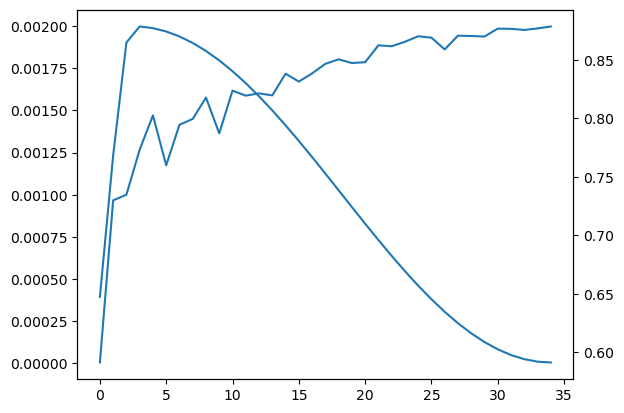

====== 1 ======


100%|██████████| 25/25 [00:02<00:00,  8.61it/s]


auc:0.7247
Validation loss decreased (inf --> -0.724713).  Saving model ...


100%|██████████| 25/25 [00:03<00:00,  8.20it/s]


auc:0.7728
Validation loss decreased (-0.724713 --> -0.772777).  Saving model ...


100%|██████████| 25/25 [00:03<00:00,  8.31it/s]


auc:0.7596
EarlyStopping counter: 1 out of 50


100%|██████████| 25/25 [00:03<00:00,  7.78it/s]


auc:0.8111
Validation loss decreased (-0.772777 --> -0.811147).  Saving model ...


100%|██████████| 25/25 [00:03<00:00,  8.15it/s]


auc:0.8056
EarlyStopping counter: 1 out of 50


100%|██████████| 25/25 [00:03<00:00,  8.18it/s]


auc:0.8080
EarlyStopping counter: 2 out of 50


100%|██████████| 25/25 [00:03<00:00,  7.75it/s]


auc:0.7656
EarlyStopping counter: 3 out of 50


100%|██████████| 25/25 [00:03<00:00,  7.68it/s]


auc:0.7993
EarlyStopping counter: 4 out of 50


100%|██████████| 25/25 [00:03<00:00,  7.90it/s]


auc:0.8303
Validation loss decreased (-0.811147 --> -0.830282).  Saving model ...


100%|██████████| 25/25 [00:03<00:00,  7.51it/s]


auc:0.8403
Validation loss decreased (-0.830282 --> -0.840350).  Saving model ...


100%|██████████| 25/25 [00:03<00:00,  8.04it/s]


auc:0.8451
Validation loss decreased (-0.840350 --> -0.845090).  Saving model ...


100%|██████████| 25/25 [00:03<00:00,  7.84it/s]


auc:0.8425
EarlyStopping counter: 1 out of 50


100%|██████████| 25/25 [00:03<00:00,  6.73it/s]


auc:0.8320
EarlyStopping counter: 2 out of 50


100%|██████████| 25/25 [00:03<00:00,  7.31it/s]


auc:0.8401
EarlyStopping counter: 3 out of 50


100%|██████████| 25/25 [00:03<00:00,  7.75it/s]


auc:0.8520
Validation loss decreased (-0.845090 --> -0.851995).  Saving model ...


100%|██████████| 25/25 [00:03<00:00,  7.39it/s]


auc:0.8307
EarlyStopping counter: 1 out of 50


100%|██████████| 25/25 [00:03<00:00,  7.51it/s]


auc:0.8476
EarlyStopping counter: 2 out of 50


100%|██████████| 25/25 [00:03<00:00,  7.50it/s]


auc:0.8470
EarlyStopping counter: 3 out of 50


100%|██████████| 25/25 [00:03<00:00,  7.73it/s]


auc:0.8582
Validation loss decreased (-0.851995 --> -0.858189).  Saving model ...


100%|██████████| 25/25 [00:03<00:00,  7.47it/s]


auc:0.8519
EarlyStopping counter: 1 out of 50


100%|██████████| 25/25 [00:03<00:00,  7.70it/s]


auc:0.8639
Validation loss decreased (-0.858189 --> -0.863899).  Saving model ...


100%|██████████| 25/25 [00:03<00:00,  7.34it/s]


auc:0.8561
EarlyStopping counter: 1 out of 50


100%|██████████| 25/25 [00:03<00:00,  7.29it/s]


auc:0.8688
Validation loss decreased (-0.863899 --> -0.868821).  Saving model ...


100%|██████████| 25/25 [00:03<00:00,  7.60it/s]


auc:0.8685
EarlyStopping counter: 1 out of 50


100%|██████████| 25/25 [00:03<00:00,  7.30it/s]


auc:0.8676
EarlyStopping counter: 2 out of 50


100%|██████████| 25/25 [00:03<00:00,  7.28it/s]


auc:0.8687
EarlyStopping counter: 3 out of 50


100%|██████████| 25/25 [00:03<00:00,  7.07it/s]


auc:0.8718
Validation loss decreased (-0.868821 --> -0.871824).  Saving model ...


100%|██████████| 25/25 [00:03<00:00,  7.14it/s]


auc:0.8763
Validation loss decreased (-0.871824 --> -0.876290).  Saving model ...


100%|██████████| 25/25 [00:03<00:00,  7.09it/s]


auc:0.8758
EarlyStopping counter: 1 out of 50


100%|██████████| 25/25 [00:03<00:00,  7.58it/s]


auc:0.8772
Validation loss decreased (-0.876290 --> -0.877215).  Saving model ...


100%|██████████| 25/25 [00:03<00:00,  7.05it/s]


auc:0.8750
EarlyStopping counter: 1 out of 50


100%|██████████| 25/25 [00:03<00:00,  7.13it/s]


auc:0.8780
Validation loss decreased (-0.877215 --> -0.877970).  Saving model ...


100%|██████████| 25/25 [00:03<00:00,  6.84it/s]


auc:0.8781
Validation loss decreased (-0.877970 --> -0.878146).  Saving model ...


100%|██████████| 25/25 [00:03<00:00,  6.98it/s]


auc:0.8786
Validation loss decreased (-0.878146 --> -0.878574).  Saving model ...


100%|██████████| 25/25 [00:03<00:00,  6.76it/s]


auc:0.8758
EarlyStopping counter: 1 out of 50


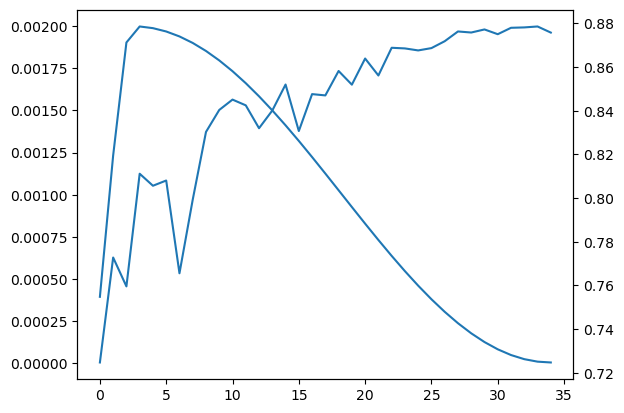

====== 2 ======


100%|██████████| 20/20 [00:03<00:00,  6.65it/s]


auc:0.8715
Validation loss decreased (inf --> -0.871520).  Saving model ...


100%|██████████| 20/20 [00:03<00:00,  6.59it/s]


auc:0.8909
Validation loss decreased (-0.871520 --> -0.890940).  Saving model ...


100%|██████████| 20/20 [00:03<00:00,  6.43it/s]


auc:0.8717
EarlyStopping counter: 1 out of 50


100%|██████████| 20/20 [00:03<00:00,  6.07it/s]


auc:0.8882
EarlyStopping counter: 2 out of 50


100%|██████████| 20/20 [00:03<00:00,  6.51it/s]


auc:0.8855
EarlyStopping counter: 3 out of 50


100%|██████████| 20/20 [00:02<00:00,  6.69it/s]


auc:0.8953
Validation loss decreased (-0.890940 --> -0.895337).  Saving model ...


100%|██████████| 20/20 [00:03<00:00,  6.64it/s]


auc:0.8904
EarlyStopping counter: 1 out of 50


100%|██████████| 20/20 [00:03<00:00,  6.27it/s]


auc:0.8914
EarlyStopping counter: 2 out of 50


100%|██████████| 20/20 [00:03<00:00,  6.46it/s]


auc:0.8933
EarlyStopping counter: 3 out of 50


100%|██████████| 20/20 [00:02<00:00,  6.89it/s]


auc:0.8959
Validation loss decreased (-0.895337 --> -0.895904).  Saving model ...


100%|██████████| 20/20 [00:03<00:00,  6.30it/s]


auc:0.9041
Validation loss decreased (-0.895904 --> -0.904119).  Saving model ...


100%|██████████| 20/20 [00:03<00:00,  6.33it/s]


auc:0.9021
EarlyStopping counter: 1 out of 50


100%|██████████| 20/20 [00:03<00:00,  6.33it/s]


auc:0.8930
EarlyStopping counter: 2 out of 50


100%|██████████| 20/20 [00:02<00:00,  6.76it/s]


auc:0.9000
EarlyStopping counter: 3 out of 50


100%|██████████| 20/20 [00:02<00:00,  6.69it/s]


auc:0.9078
Validation loss decreased (-0.904119 --> -0.907750).  Saving model ...


100%|██████████| 20/20 [00:03<00:00,  6.49it/s]


auc:0.8957
EarlyStopping counter: 1 out of 50


100%|██████████| 20/20 [00:03<00:00,  6.63it/s]


auc:0.9029
EarlyStopping counter: 2 out of 50


100%|██████████| 20/20 [00:03<00:00,  6.65it/s]


auc:0.8979
EarlyStopping counter: 3 out of 50


100%|██████████| 20/20 [00:03<00:00,  6.38it/s]


auc:0.9017
EarlyStopping counter: 4 out of 50


100%|██████████| 20/20 [00:02<00:00,  6.70it/s]


auc:0.8932
EarlyStopping counter: 5 out of 50


100%|██████████| 20/20 [00:03<00:00,  6.45it/s]


auc:0.8933
EarlyStopping counter: 6 out of 50


100%|██████████| 20/20 [00:03<00:00,  6.65it/s]


auc:0.9008
EarlyStopping counter: 7 out of 50


100%|██████████| 20/20 [00:03<00:00,  6.56it/s]


auc:0.8994
EarlyStopping counter: 8 out of 50


100%|██████████| 20/20 [00:02<00:00,  6.81it/s]


auc:0.8957
EarlyStopping counter: 9 out of 50


100%|██████████| 20/20 [00:03<00:00,  6.58it/s]


auc:0.9071
EarlyStopping counter: 10 out of 50


100%|██████████| 20/20 [00:03<00:00,  6.43it/s]


auc:0.9073
EarlyStopping counter: 11 out of 50


100%|██████████| 20/20 [00:03<00:00,  6.40it/s]


auc:0.9007
EarlyStopping counter: 12 out of 50


100%|██████████| 20/20 [00:03<00:00,  6.50it/s]


auc:0.8927
EarlyStopping counter: 13 out of 50


100%|██████████| 20/20 [00:02<00:00,  6.78it/s]


auc:0.8993
EarlyStopping counter: 14 out of 50


100%|██████████| 20/20 [00:02<00:00,  6.72it/s]


auc:0.8967
EarlyStopping counter: 15 out of 50


100%|██████████| 20/20 [00:03<00:00,  6.24it/s]


auc:0.8990
EarlyStopping counter: 16 out of 50


100%|██████████| 20/20 [00:03<00:00,  6.66it/s]


auc:0.9003
EarlyStopping counter: 17 out of 50


100%|██████████| 20/20 [00:03<00:00,  6.45it/s]


auc:0.9007
EarlyStopping counter: 18 out of 50


100%|██████████| 20/20 [00:03<00:00,  6.45it/s]


auc:0.9026
EarlyStopping counter: 19 out of 50


100%|██████████| 20/20 [00:03<00:00,  6.59it/s]


auc:0.9016
EarlyStopping counter: 20 out of 50


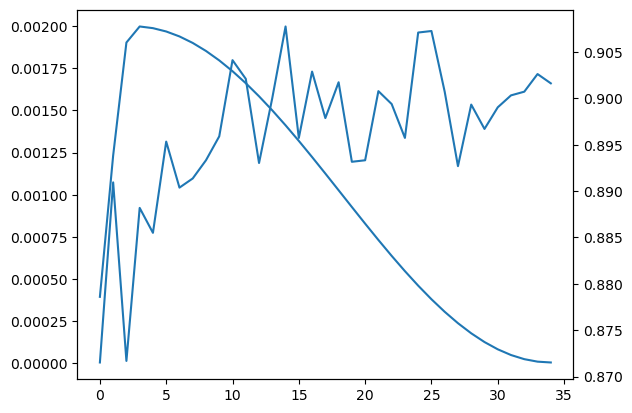

====== 3 ======


100%|██████████| 25/25 [00:03<00:00,  6.91it/s]


auc:0.8574
Validation loss decreased (inf --> -0.857418).  Saving model ...


100%|██████████| 25/25 [00:03<00:00,  7.10it/s]


auc:0.8963
Validation loss decreased (-0.857418 --> -0.896294).  Saving model ...


100%|██████████| 25/25 [00:03<00:00,  6.97it/s]


auc:0.9081
Validation loss decreased (-0.896294 --> -0.908134).  Saving model ...


100%|██████████| 25/25 [00:03<00:00,  7.17it/s]


auc:0.9052
EarlyStopping counter: 1 out of 50


100%|██████████| 25/25 [00:03<00:00,  6.71it/s]


auc:0.9185
Validation loss decreased (-0.908134 --> -0.918521).  Saving model ...


100%|██████████| 25/25 [00:03<00:00,  7.22it/s]


auc:0.9085
EarlyStopping counter: 1 out of 50


100%|██████████| 25/25 [00:03<00:00,  6.67it/s]


auc:0.9086
EarlyStopping counter: 2 out of 50


100%|██████████| 25/25 [00:03<00:00,  7.33it/s]


auc:0.9083
EarlyStopping counter: 3 out of 50


100%|██████████| 25/25 [00:03<00:00,  6.98it/s]


auc:0.9090
EarlyStopping counter: 4 out of 50


100%|██████████| 25/25 [00:03<00:00,  7.03it/s]


auc:0.9197
Validation loss decreased (-0.918521 --> -0.919706).  Saving model ...


100%|██████████| 25/25 [00:03<00:00,  7.10it/s]


auc:0.9214
Validation loss decreased (-0.919706 --> -0.921385).  Saving model ...


100%|██████████| 25/25 [00:03<00:00,  7.03it/s]


auc:0.9201
EarlyStopping counter: 1 out of 50


100%|██████████| 25/25 [00:03<00:00,  6.65it/s]


auc:0.9151
EarlyStopping counter: 2 out of 50


100%|██████████| 25/25 [00:03<00:00,  6.95it/s]


auc:0.9140
EarlyStopping counter: 3 out of 50


100%|██████████| 25/25 [00:03<00:00,  6.88it/s]


auc:0.9292
Validation loss decreased (-0.921385 --> -0.929213).  Saving model ...


100%|██████████| 25/25 [00:03<00:00,  6.85it/s]


auc:0.9304
Validation loss decreased (-0.929213 --> -0.930402).  Saving model ...


100%|██████████| 25/25 [00:03<00:00,  6.87it/s]


auc:0.9293
EarlyStopping counter: 1 out of 50


100%|██████████| 25/25 [00:03<00:00,  6.74it/s]


auc:0.9226
EarlyStopping counter: 2 out of 50


100%|██████████| 25/25 [00:03<00:00,  6.67it/s]


auc:0.9319
Validation loss decreased (-0.930402 --> -0.931855).  Saving model ...


100%|██████████| 25/25 [00:03<00:00,  7.07it/s]


auc:0.9269
EarlyStopping counter: 1 out of 50


100%|██████████| 25/25 [00:03<00:00,  6.64it/s]


auc:0.9283
EarlyStopping counter: 2 out of 50


100%|██████████| 25/25 [00:03<00:00,  6.64it/s]


auc:0.9299
EarlyStopping counter: 3 out of 50


100%|██████████| 25/25 [00:03<00:00,  6.68it/s]


auc:0.9226
EarlyStopping counter: 4 out of 50


100%|██████████| 25/25 [00:03<00:00,  6.97it/s]


auc:0.9222
EarlyStopping counter: 5 out of 50


100%|██████████| 25/25 [00:03<00:00,  6.58it/s]


auc:0.9270
EarlyStopping counter: 6 out of 50


100%|██████████| 25/25 [00:03<00:00,  6.76it/s]


auc:0.9274
EarlyStopping counter: 7 out of 50


100%|██████████| 25/25 [00:03<00:00,  6.52it/s]


auc:0.9253
EarlyStopping counter: 8 out of 50


100%|██████████| 25/25 [00:03<00:00,  6.66it/s]


auc:0.9176
EarlyStopping counter: 9 out of 50


100%|██████████| 25/25 [00:03<00:00,  6.36it/s]


auc:0.9198
EarlyStopping counter: 10 out of 50


100%|██████████| 25/25 [00:03<00:00,  6.85it/s]


auc:0.9296
EarlyStopping counter: 11 out of 50


100%|██████████| 25/25 [00:03<00:00,  6.61it/s]


auc:0.9265
EarlyStopping counter: 12 out of 50


100%|██████████| 25/25 [00:03<00:00,  6.45it/s]


auc:0.9237
EarlyStopping counter: 13 out of 50


100%|██████████| 25/25 [00:03<00:00,  6.51it/s]


auc:0.9270
EarlyStopping counter: 14 out of 50


100%|██████████| 25/25 [00:03<00:00,  6.63it/s]


auc:0.9271
EarlyStopping counter: 15 out of 50


100%|██████████| 25/25 [00:03<00:00,  6.87it/s]


auc:0.9271
EarlyStopping counter: 16 out of 50


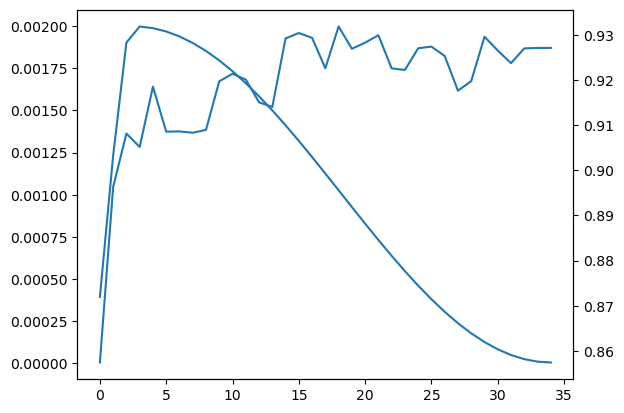

====== 4 ======


100%|██████████| 27/27 [00:03<00:00,  6.80it/s]


auc:0.8486
Validation loss decreased (inf --> -0.848628).  Saving model ...


100%|██████████| 27/27 [00:03<00:00,  6.85it/s]


auc:0.8595
Validation loss decreased (-0.848628 --> -0.859544).  Saving model ...


100%|██████████| 27/27 [00:03<00:00,  6.97it/s]


auc:0.8849
Validation loss decreased (-0.859544 --> -0.884923).  Saving model ...


100%|██████████| 27/27 [00:04<00:00,  6.68it/s]


auc:0.8651
EarlyStopping counter: 1 out of 50


100%|██████████| 27/27 [00:04<00:00,  6.37it/s]


auc:0.8831
EarlyStopping counter: 2 out of 50


100%|██████████| 27/27 [00:04<00:00,  6.72it/s]


auc:0.8856
Validation loss decreased (-0.884923 --> -0.885630).  Saving model ...


100%|██████████| 27/27 [00:04<00:00,  6.71it/s]


auc:0.8831
EarlyStopping counter: 1 out of 50


100%|██████████| 27/27 [00:04<00:00,  6.54it/s]


auc:0.9005
Validation loss decreased (-0.885630 --> -0.900509).  Saving model ...


100%|██████████| 27/27 [00:04<00:00,  6.54it/s]


auc:0.8901
EarlyStopping counter: 1 out of 50


100%|██████████| 27/27 [00:04<00:00,  6.53it/s]


auc:0.8724
EarlyStopping counter: 2 out of 50


100%|██████████| 27/27 [00:04<00:00,  6.33it/s]


auc:0.8979
EarlyStopping counter: 3 out of 50


100%|██████████| 27/27 [00:04<00:00,  6.55it/s]


auc:0.9042
Validation loss decreased (-0.900509 --> -0.904224).  Saving model ...


100%|██████████| 27/27 [00:04<00:00,  6.46it/s]


auc:0.9093
Validation loss decreased (-0.904224 --> -0.909349).  Saving model ...


100%|██████████| 27/27 [00:04<00:00,  6.20it/s]


auc:0.8875
EarlyStopping counter: 1 out of 50


100%|██████████| 27/27 [00:04<00:00,  6.40it/s]


auc:0.9019
EarlyStopping counter: 2 out of 50


100%|██████████| 27/27 [00:04<00:00,  6.43it/s]


auc:0.8959
EarlyStopping counter: 3 out of 50


100%|██████████| 27/27 [00:04<00:00,  6.36it/s]


auc:0.8975
EarlyStopping counter: 4 out of 50


100%|██████████| 27/27 [00:04<00:00,  6.44it/s]


auc:0.9141
Validation loss decreased (-0.909349 --> -0.914075).  Saving model ...


100%|██████████| 27/27 [00:04<00:00,  6.37it/s]


auc:0.9027
EarlyStopping counter: 1 out of 50


100%|██████████| 27/27 [00:04<00:00,  6.20it/s]


auc:0.8906
EarlyStopping counter: 2 out of 50


100%|██████████| 27/27 [00:04<00:00,  6.34it/s]


auc:0.8957
EarlyStopping counter: 3 out of 50


100%|██████████| 27/27 [00:04<00:00,  6.42it/s]


auc:0.9111
EarlyStopping counter: 4 out of 50


100%|██████████| 27/27 [00:04<00:00,  6.37it/s]


auc:0.8994
EarlyStopping counter: 5 out of 50


100%|██████████| 27/27 [00:04<00:00,  5.99it/s]


auc:0.9077
EarlyStopping counter: 6 out of 50


100%|██████████| 27/27 [00:04<00:00,  6.46it/s]


auc:0.8989
EarlyStopping counter: 7 out of 50


100%|██████████| 27/27 [00:04<00:00,  6.41it/s]


auc:0.9029
EarlyStopping counter: 8 out of 50


100%|██████████| 27/27 [00:04<00:00,  6.20it/s]


auc:0.9078
EarlyStopping counter: 9 out of 50


100%|██████████| 27/27 [00:04<00:00,  6.35it/s]


auc:0.9039
EarlyStopping counter: 10 out of 50


100%|██████████| 27/27 [00:04<00:00,  6.25it/s]


auc:0.9042
EarlyStopping counter: 11 out of 50


100%|██████████| 27/27 [00:04<00:00,  6.28it/s]


auc:0.9021
EarlyStopping counter: 12 out of 50


100%|██████████| 27/27 [00:04<00:00,  6.44it/s]


auc:0.9041
EarlyStopping counter: 13 out of 50


100%|██████████| 27/27 [00:04<00:00,  6.08it/s]


auc:0.9009
EarlyStopping counter: 14 out of 50


100%|██████████| 27/27 [00:04<00:00,  6.53it/s]


auc:0.9021
EarlyStopping counter: 15 out of 50


100%|██████████| 27/27 [00:04<00:00,  6.29it/s]


auc:0.8985
EarlyStopping counter: 16 out of 50


100%|██████████| 27/27 [00:04<00:00,  6.26it/s]


auc:0.9013
EarlyStopping counter: 17 out of 50


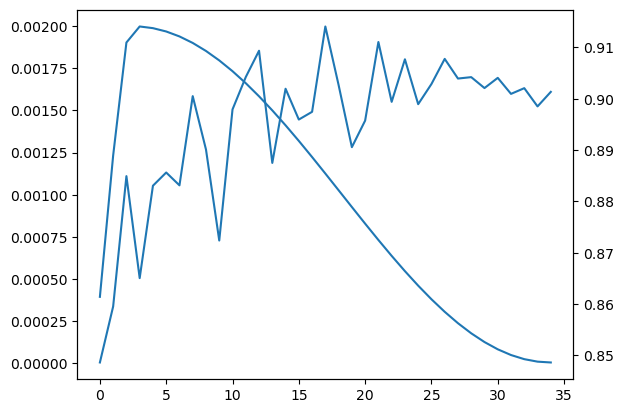

CPU times: user 3h 58min 53s, sys: 3h 53min 49s, total: 7h 52min 43s
Wall time: 8h 21min 49s


In [19]:
%%time
if is_train:
    for fold in range(0, 5):
        print(f"====== {fold} ======")

        net = Unet()
        net.to(device)

        base_optimizer = optim.AdamW
        optimizer = SAM(
            net.parameters(), base_optimizer, lr=Config.LR, weight_decay=1.0e-02
        )

        train_dataset = CVDataSet(
            data_set[fold]["train_img"],
            get_augmentation(),
            labels=data_set[fold]["train_label"],
            data_type="train",
            crop_size=Config.IMG_SIZE,
        )
        trainloader = DataLoader(
            train_dataset,
            batch_size=Config.BATCH_SIZE,
            pin_memory=True,
            shuffle=True,
            drop_last=True,
            num_workers=Config.NUM_WORKERS,
        )

        train_dataset_ir = CVDataSet(
            data_set[fold]["train_img"],
            get_augmentation(),
            labels=data_set[fold]["train_ir"],
            data_type="train",
            crop_size=Config.IMG_SIZE,
        )
        trainloader_ir = DataLoader(
            train_dataset_ir,
            batch_size=Config.BATCH_SIZE,
            pin_memory=True,
            shuffle=True,
            drop_last=True,
            num_workers=Config.NUM_WORKERS,
        )

        
        valid_dataloaders = []

        for j in range(Config.PREDICT_STRIDE):

            valid_dataset = CVDataSet(
                [
                    data_set[fold]["valid_img"][0][
                        :,
                        (Config.IMG_SIZE // Config.PREDICT_STRIDE) * j :,
                        (Config.IMG_SIZE // Config.PREDICT_STRIDE) * j :,
                    ]
                ],
                get_test_augmentation(),
                labels=[
                    data_set[fold]["valid_label"][0][
                        (Config.IMG_SIZE // Config.PREDICT_STRIDE) * j :,
                        (Config.IMG_SIZE // Config.PREDICT_STRIDE) * j :,
                    ]
                ],
                data_type="valid",
                crop_size=Config.IMG_SIZE,
            )

            validloader = DataLoader(
                valid_dataset,
                batch_size=Config.BATCH_SIZE,
                pin_memory=True,
                num_workers=Config.NUM_WORKERS,
            )
            valid_dataloaders.append(validloader)

        early_stopping = EarlyStopping(
            patience=Config.PATIENCE, verbose=True, fold=fold
        )

        scheduler = torch.optim.lr_scheduler.OneCycleLR(
            optimizer,
            epochs=Config.EPOCH,
            steps_per_epoch=len(trainloader),
            max_lr=Config.MAX_LR,
            pct_start=0.1,
            anneal_strategy="cos",
            div_factor=1.0e2,
            final_div_factor=5,
        )

        val_metrics = []
        learning_rates = []

        for epoch in range(Config.EPOCH):

            running_loss = 0.0
            train_rmse_list = []
            
            if epoch < 20:
                loader = trainloader_ir
            else:
                loader = trainloader
        
            n_iter = len(loader)
            with tqdm(enumerate(loader), total=n_iter) as pbar:
                #! ADD CLASS
                for i, (img, target_mask, target_class) in pbar:

                    net.train()
                    #! ADD CLASS                    
                    img, target_mask, target_class = img.to(device).float(), target_mask.to(device).float(), target_class.to(device).float().view(-1,1)
                    outputs_mask, outputs_class = net(img)
                    loss = criterion(outputs_class, target_class, outputs_mask.squeeze(), target_mask)
                    
                    loss.backward()  # Backward pass
                    optimizer.first_step(zero_grad=True)

                    outputs_mask, outputs_class = net(img)
                    criterion(outputs_class, target_class, outputs_mask.squeeze(), target_mask).backward()

                    optimizer.second_step(zero_grad=True)
                    net.zero_grad()

                    # print statistics
                    running_loss += loss.item()

                    outputs_np = outputs_mask.to("cpu").detach().numpy().copy()

                    pbar.set_postfix(
                        OrderedDict(
                            epoch="{:>10}".format(epoch),
                            loss="{:.4f}".format(loss.item()),
                        )
                    )
                    scheduler.step()

            pred_tile_imgs = []
            for j, validloader in enumerate(valid_dataloaders):

                ## shift test
                val_preds = []
                val_class = []
                valid_targets = []
                
                n_iter_val = len(validloader)
                #! ADD CLASS
                for i, (img, target_mask, target_class) in tqdm(
                    enumerate(validloader), total=n_iter_val, smoothing=0
                ):
                    net.eval()

                    with torch.no_grad():
                        #! ADD CLASS
                        img, target_mask, target_class = (
                                        img.to(device).float(),
                                        target_mask.to(device).float(),
                                        target_class.to(device).float().view(-1,1),
                                    )
                        outputs_mask, outputs_class  = net(img)
                        outputs_mask = outputs_mask.sigmoid()
                        
                        outputs_np = outputs_mask.to("cpu").detach().numpy().copy()
                        outputs_class = outputs_class.detach().cpu().numpy().ravel().tolist()
                        
                        val_preds.append(outputs_np)
                        val_class.append(outputs_class)
                        valid_targets.append(target_mask.to("cpu").detach().numpy().copy())

                ## 端を切る
                w_count = math.ceil(
                    data_set[fold]["valid_label"][0][
                        (Config.IMG_SIZE // Config.PREDICT_STRIDE) * j :,
                        (Config.IMG_SIZE // Config.PREDICT_STRIDE) * j :,
                    ].shape[1]
                    / Config.IMG_SIZE
                )
                h_count = math.ceil(
                    data_set[fold]["valid_label"][0][
                        (Config.IMG_SIZE // Config.PREDICT_STRIDE) * j :,
                        (Config.IMG_SIZE // Config.PREDICT_STRIDE) * j :,
                    ].shape[0]
                    / Config.IMG_SIZE
                )

                tile_arry = []
                stack_pred = np.vstack(val_preds).reshape(
                    -1, Config.IMG_SIZE, Config.IMG_SIZE
                )
                for h_i in range(h_count):
                    tile_arry.append(stack_pred[h_i * w_count : (h_i + 1) * w_count])

                _pred_tile_img = concat_tile(tile_arry)
                _pred_tile_img = np.where(
                    data_set[fold]["valid_mask"][0][
                        (Config.IMG_SIZE // Config.PREDICT_STRIDE) * j :,
                        (Config.IMG_SIZE // Config.PREDICT_STRIDE) * j :,
                    ]
                    > 1,
                    _pred_tile_img[
                        : data_set[fold]["valid_label"][0][
                            (Config.IMG_SIZE // Config.PREDICT_STRIDE) * j :,
                            (Config.IMG_SIZE // Config.PREDICT_STRIDE) * j :,
                        ].shape[0],
                        : data_set[fold]["valid_label"][0][
                            (Config.IMG_SIZE // Config.PREDICT_STRIDE) * j :,
                            (Config.IMG_SIZE // Config.PREDICT_STRIDE) * j :,
                        ].shape[1],
                    ],
                    0,
                )

                shift_pred_tile_img = np.zeros(
                    (
                        data_set[fold]["valid_img"][0].shape[1],
                        data_set[fold]["valid_img"][0].shape[2],
                    )
                )
                shift_pred_tile_img[
                    (Config.IMG_SIZE // Config.PREDICT_STRIDE) * j :,
                    (Config.IMG_SIZE // Config.PREDICT_STRIDE) * j :,
                ] = _pred_tile_img

                # plt.imshow(shift_pred_tile_img)
                # plt.show()

                pred_tile_imgs.append(shift_pred_tile_img)

            pred_tile_img = np.sum(pred_tile_imgs, axis=0) / (Config.PREDICT_STRIDE)

            auc = roc_auc_score(
                data_set[fold]["valid_label"][0].reshape(-1),
                pred_tile_img.reshape(-1),
            )

#             logger.info("auc:{:.4f}".format(auc))
            print("auc:{:.4f}".format(auc))

            lr = optimizer.param_groups[0]["lr"]

            val_metrics.append(auc)
            learning_rates.append(lr)

            early_stopping(-auc, net)

            if early_stopping.early_stop:
                print("Early stopping")
#                 logger.info("Early stopping")
                break

        fig = plt.figure()
        ax1 = fig.add_subplot(111)
        ax1.plot(learning_rates)
        ax2 = ax1.twinx()
        ax2.plot(val_metrics)
        plt.show()

        del (
            net,
            validloader,
            trainloader,
            train_dataset,
            valid_dataset,
            img,
            target_mask,
            target_class,
            outputs_mask,
            outputs_class,
        )
        torch.cuda.empty_cache()
        gc.collect()
        

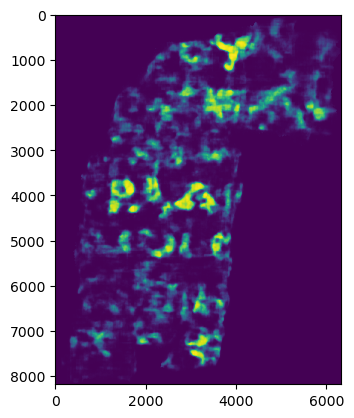

In [20]:
plt.imshow(pred_tile_img)

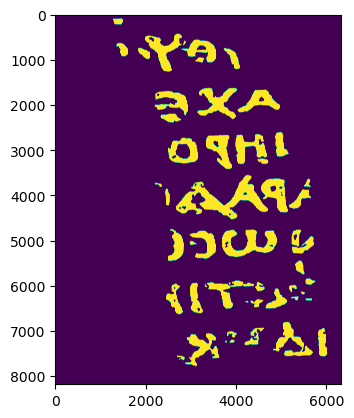

In [21]:
plt.imshow(np.flip(data_set[fold]["valid_label"][0], 1))

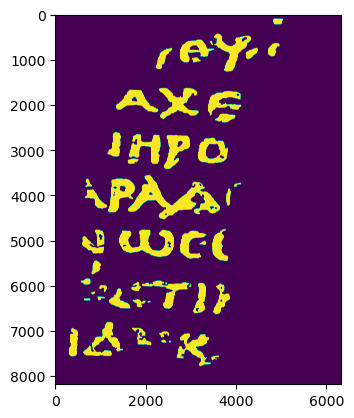

In [22]:
plt.imshow(data_set[fold]["valid_label"][0])

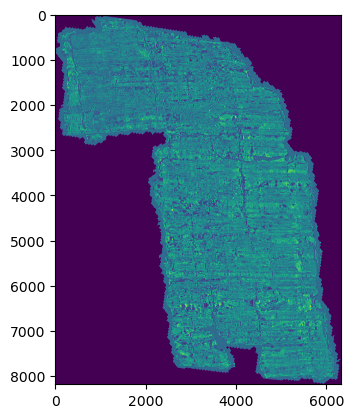

In [23]:
plt.imshow(np.flip(data_set[fold]["valid_img"][0], 2)[0])

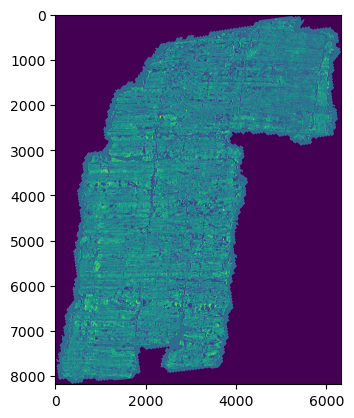

In [24]:
plt.imshow(data_set[fold]["valid_img"][0][0])

# valid

====== 0 ======


  0%|          | 0/30 [00:00<?, ?it/s]


ValueError: too many values to unpack (expected 2)

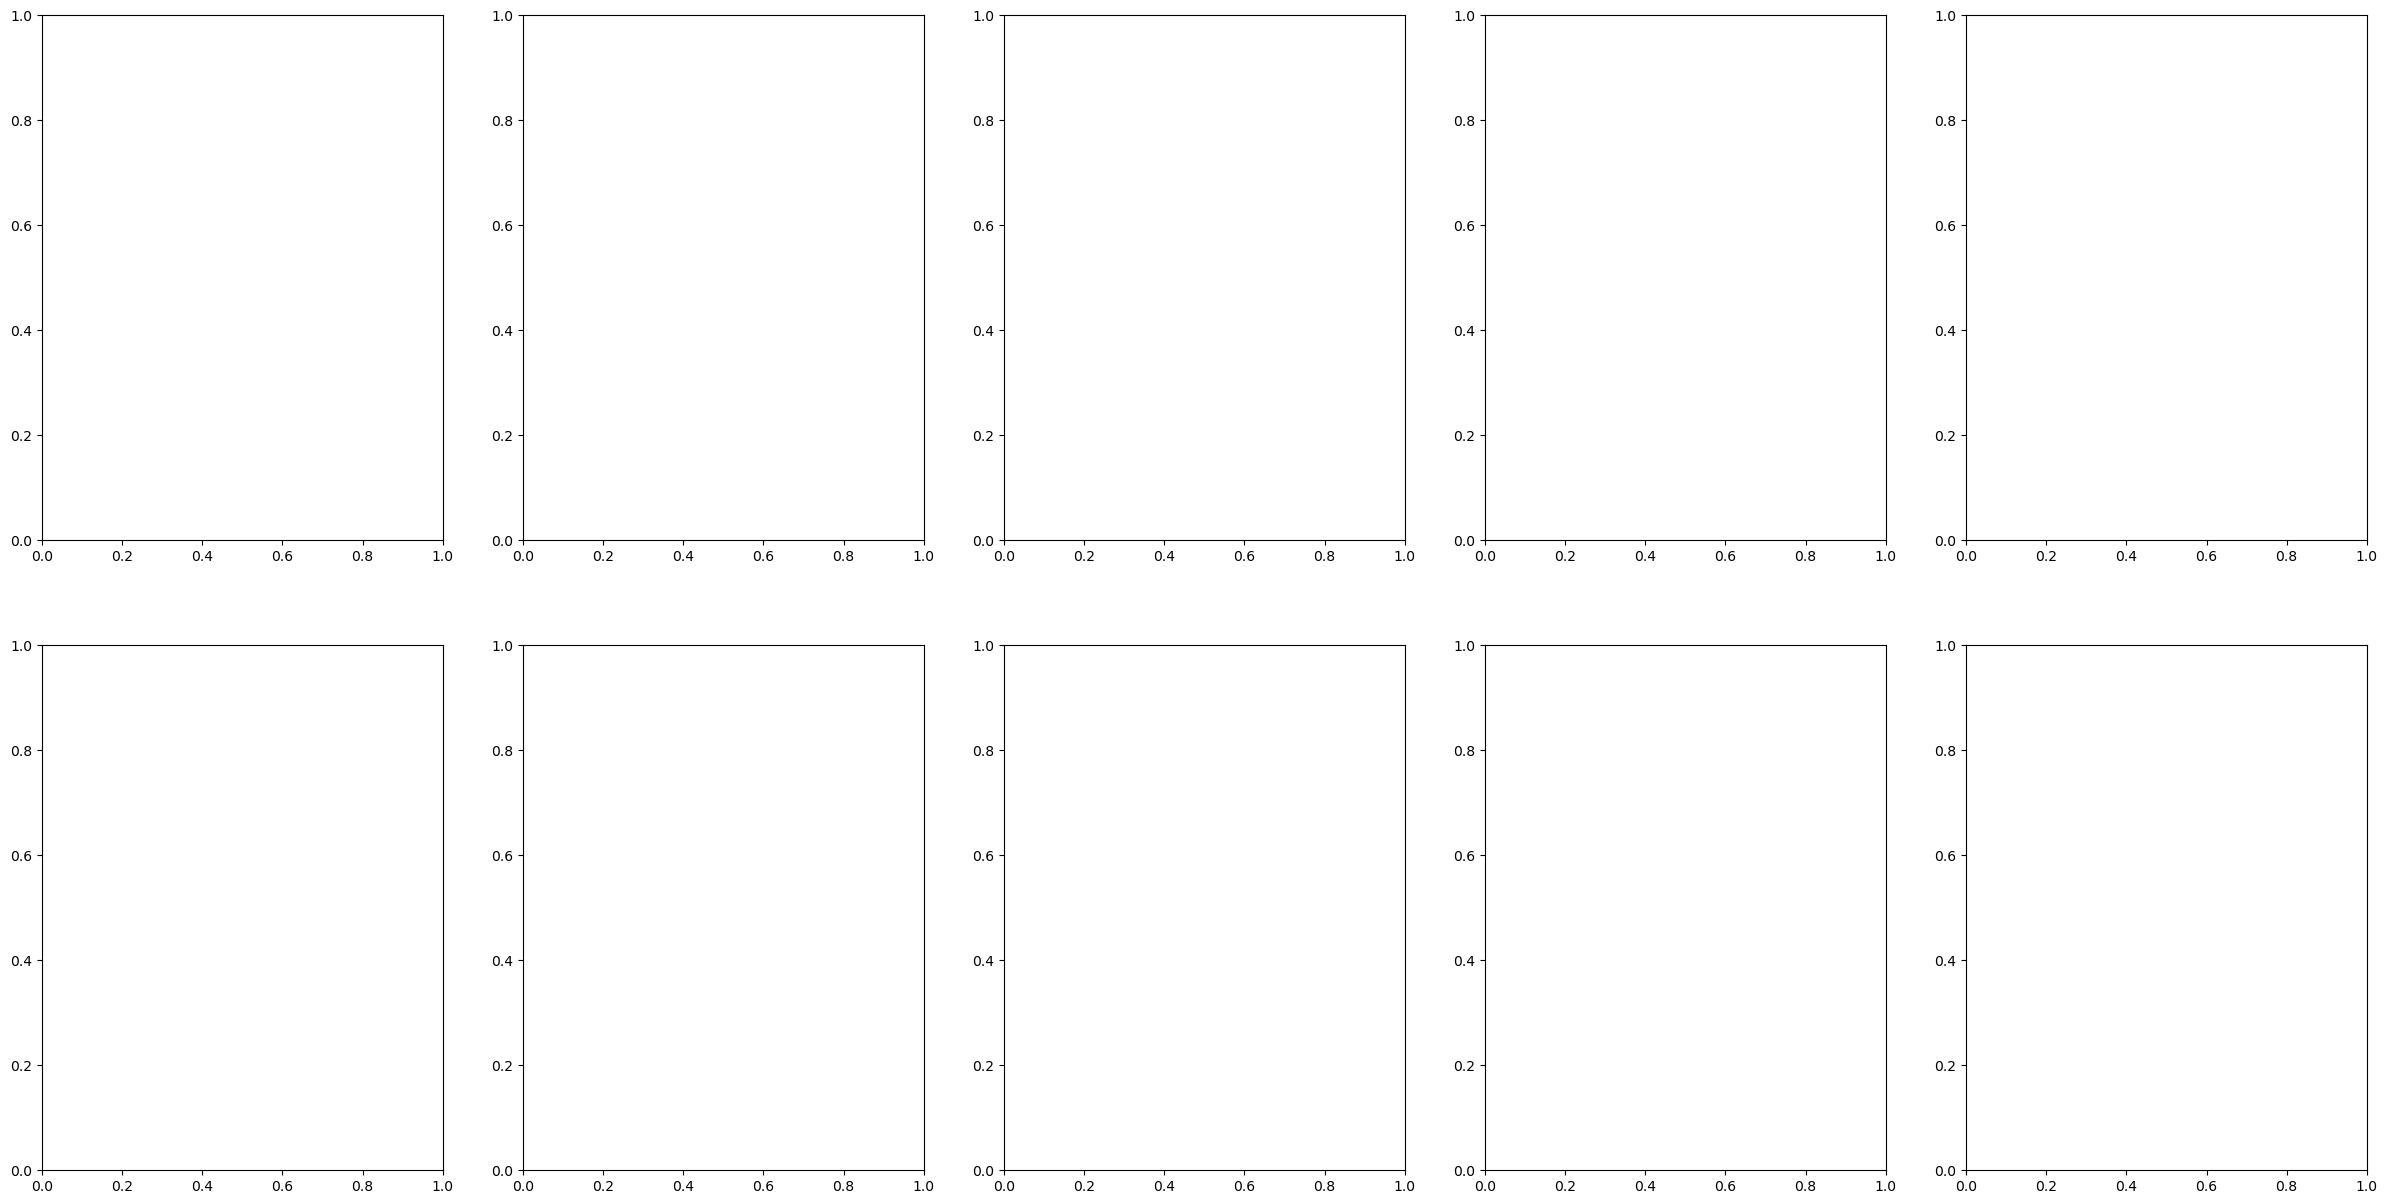

In [25]:
%%time
if is_train:
    all_preds = []
    all_masks = []
    aucs = {}
    for fold in range(0, 5):
        # for fold in [0, 2]:
        print(f"====== {fold} ======")

        net = Unet()
        net.load_state_dict(torch.load(OUTPUT_DIR/ f"{EXP_NAME}_{fold}.pt"))
        net.to(device)

        img_idx_nums = []
        for img_idx_num in range(3):

            valid_dataloaders = []

            for j in range(Config.PREDICT_STRIDE):

                valid_dataset = CVDataSet(
                    [
                        data_set[fold]["valid_img"][img_idx_num][
                            :,
                            (Config.IMG_SIZE // Config.PREDICT_STRIDE) * j :,
                            (Config.IMG_SIZE // Config.PREDICT_STRIDE) * j :,
                        ]
                    ],
                    get_test_augmentation(),
                    labels=[
                        data_set[fold]["valid_label"][0][
                            (Config.IMG_SIZE // Config.PREDICT_STRIDE) * j :,
                            (Config.IMG_SIZE // Config.PREDICT_STRIDE) * j :,
                        ]
                    ],
                    data_type="valid",
                    crop_size=Config.IMG_SIZE,
                )

                validloader = DataLoader(
                    valid_dataset,
                    batch_size=Config.BATCH_SIZE,
                    pin_memory=True,
                    num_workers=Config.NUM_WORKERS,
                )
                valid_dataloaders.append(validloader)

            h_flip_valid_dataloaders = []

            for j in range(Config.PREDICT_STRIDE):

                valid_dataset = CVDataSet(
                    [
                        np.flip(data_set[fold]["valid_img"][img_idx_num], 2)[
                            :,
                            (Config.IMG_SIZE // Config.PREDICT_STRIDE) * j :,
                            (Config.IMG_SIZE // Config.PREDICT_STRIDE) * j :,
                        ]
                    ],
                    get_test_augmentation(),
                    labels=[
                        np.flip(data_set[fold]["valid_label"][0], 1)[
                            (Config.IMG_SIZE // Config.PREDICT_STRIDE) * j :,
                            (Config.IMG_SIZE // Config.PREDICT_STRIDE) * j :,
                        ]
                    ],
                    data_type="valid",
                    crop_size=Config.IMG_SIZE,
                )

                validloader = DataLoader(
                    valid_dataset,
                    batch_size=Config.BATCH_SIZE,
                    pin_memory=True,
                    num_workers=Config.NUM_WORKERS,
                )
                h_flip_valid_dataloaders.append(validloader)

            fig, axes = plt.subplots(
                2, math.ceil(Config.PREDICT_STRIDE / 2), figsize=(30, 15)
            )
            axes = axes.reshape(-1)
            pred_tile_imgs = []

            for j, validloader in enumerate(valid_dataloaders):

                ## shift test
                val_preds = []
                valid_targets = []
                n_iter_val = len(validloader)
                for i, (img, target) in tqdm(
                    enumerate(validloader), total=n_iter_val, smoothing=0
                ):
                    net.eval()

                    with torch.no_grad():
                        img, target = (
                            img.to(device).float(),
                            target.to(device).float(),
                        )
                        outputs = net(img)
                        outputs = outputs.sigmoid()
                        outputs_np = outputs.to("cpu").detach().numpy().copy()

                        val_preds.append(outputs_np)
                        valid_targets.append(target.to("cpu").detach().numpy().copy())

                ## 端を切る
                w_count = math.ceil(
                    data_set[fold]["valid_label"][0][
                        (Config.IMG_SIZE // Config.PREDICT_STRIDE) * j :,
                        (Config.IMG_SIZE // Config.PREDICT_STRIDE) * j :,
                    ].shape[1]
                    / Config.IMG_SIZE
                )
                h_count = math.ceil(
                    data_set[fold]["valid_label"][0][
                        (Config.IMG_SIZE // Config.PREDICT_STRIDE) * j :,
                        (Config.IMG_SIZE // Config.PREDICT_STRIDE) * j :,
                    ].shape[0]
                    / Config.IMG_SIZE
                )

                tile_arry = []
                stack_pred = np.vstack(val_preds).reshape(
                    -1, Config.IMG_SIZE, Config.IMG_SIZE
                )
                for h_i in range(h_count):
                    tile_arry.append(stack_pred[h_i * w_count : (h_i + 1) * w_count])

                _pred_tile_img = concat_tile(tile_arry)
                _pred_tile_img = np.where(
                    data_set[fold]["valid_mask"][0][
                        (Config.IMG_SIZE // Config.PREDICT_STRIDE) * j :,
                        (Config.IMG_SIZE // Config.PREDICT_STRIDE) * j :,
                    ]
                    > 1,
                    _pred_tile_img[
                        : data_set[fold]["valid_label"][0][
                            (Config.IMG_SIZE // Config.PREDICT_STRIDE) * j :,
                            (Config.IMG_SIZE // Config.PREDICT_STRIDE) * j :,
                        ].shape[0],
                        : data_set[fold]["valid_label"][0][
                            (Config.IMG_SIZE // Config.PREDICT_STRIDE) * j :,
                            (Config.IMG_SIZE // Config.PREDICT_STRIDE) * j :,
                        ].shape[1],
                    ],
                    0,
                )

                axes[j].imshow(_pred_tile_img)

                shift_pred_tile_img = np.zeros(
                    (
                        data_set[fold]["valid_img"][0].shape[1],
                        data_set[fold]["valid_img"][0].shape[2],
                    )
                )
                shift_pred_tile_img[
                    (Config.IMG_SIZE // Config.PREDICT_STRIDE) * j :,
                    (Config.IMG_SIZE // Config.PREDICT_STRIDE) * j :,
                ] = _pred_tile_img

                pred_tile_imgs.append(shift_pred_tile_img)

            plt.show()

            pred_tile_img_idx = np.sum(pred_tile_imgs, axis=0) / Config.PREDICT_STRIDE
            img_idx_nums.append(pred_tile_img_idx)

            # ここから HFLIP

            fig, axes = plt.subplots(
                2, math.ceil(Config.PREDICT_STRIDE / 2), figsize=(30, 15)
            )
            axes = axes.reshape(-1)
            pred_tile_imgs = []

            for j, validloader in enumerate(h_flip_valid_dataloaders):

                ## shift test
                val_preds = []
                valid_targets = []
                n_iter_val = len(validloader)
                for i, (img, target) in tqdm(
                    enumerate(validloader), total=n_iter_val, smoothing=0
                ):
                    net.eval()

                    with torch.no_grad():
                        img, target = (
                            img.to(device).float(),
                            target.to(device).float(),
                        )
                        outputs = net(img)
                        outputs = outputs.sigmoid()
                        outputs_np = outputs.to("cpu").detach().numpy().copy()

                        val_preds.append(outputs_np)
                        valid_targets.append(target.to("cpu").detach().numpy().copy())

                ## 端を切る
                w_count = math.ceil(
                    data_set[fold]["valid_label"][0][
                        (Config.IMG_SIZE // Config.PREDICT_STRIDE) * j :,
                        (Config.IMG_SIZE // Config.PREDICT_STRIDE) * j :,
                    ].shape[1]
                    / Config.IMG_SIZE
                )
                h_count = math.ceil(
                    data_set[fold]["valid_label"][0][
                        (Config.IMG_SIZE // Config.PREDICT_STRIDE) * j :,
                        (Config.IMG_SIZE // Config.PREDICT_STRIDE) * j :,
                    ].shape[0]
                    / Config.IMG_SIZE
                )

                tile_arry = []
                stack_pred = np.vstack(val_preds).reshape(
                    -1, Config.IMG_SIZE, Config.IMG_SIZE
                )
                for h_i in range(h_count):
                    tile_arry.append(stack_pred[h_i * w_count : (h_i + 1) * w_count])

                _pred_tile_img = concat_tile(tile_arry)
                _pred_tile_img = np.where(
                    np.flip(data_set[fold]["valid_mask"][0], 1)[
                        (Config.IMG_SIZE // Config.PREDICT_STRIDE) * j :,
                        (Config.IMG_SIZE // Config.PREDICT_STRIDE) * j :,
                    ]
                    > 1,
                    _pred_tile_img[
                        : data_set[fold]["valid_label"][0][
                            (Config.IMG_SIZE // Config.PREDICT_STRIDE) * j :,
                            (Config.IMG_SIZE // Config.PREDICT_STRIDE) * j :,
                        ].shape[0],
                        : data_set[fold]["valid_label"][0][
                            (Config.IMG_SIZE // Config.PREDICT_STRIDE) * j :,
                            (Config.IMG_SIZE // Config.PREDICT_STRIDE) * j :,
                        ].shape[1],
                    ],
                    0,
                )

                axes[j].imshow(_pred_tile_img)

                shift_pred_tile_img = np.zeros(
                    (
                        data_set[fold]["valid_img"][0].shape[1],
                        data_set[fold]["valid_img"][0].shape[2],
                    )
                )
                shift_pred_tile_img[
                    (Config.IMG_SIZE // Config.PREDICT_STRIDE) * j :,
                    (Config.IMG_SIZE // Config.PREDICT_STRIDE) * j :,
                ] = _pred_tile_img

                pred_tile_imgs.append(shift_pred_tile_img)

            plt.show()

            pred_tile_img_idx = np.sum(pred_tile_imgs, axis=0) / Config.PREDICT_STRIDE

            # plt.imshow(pred_tile_img_idx)
            # plt.show()

            # plt.imshow(np.fliplr(pred_tile_img_idx))
            # plt.show()

            img_idx_nums.append(np.flip(pred_tile_img_idx, 1))

        pred_tile_img = np.sum(img_idx_nums, axis=0) / 6  # うえにもある

        plt.figure(figsize=(10, 10))
        plt.imshow(pred_tile_img)
        plt.show()

        auc = roc_auc_score(
            data_set[fold]["valid_label"][0].reshape(-1),
            pred_tile_img.reshape(-1),
        )

        aucs[f"auc{fold}"] = auc

        plt.figure(figsize=(10, 10))
        plt.imshow(np.where(cv2.GaussianBlur(pred_tile_img, (65, 65), 32) > 0.3, 1, 0))
        plt.show()

        np.save(
            str(OUTPUT_DIR / f'{HOST}_{NB}_oof_img{data_set[fold]["valid_img_num"]}'),
            cv2.GaussianBlur(pred_tile_img, (65, 65), 32),
        )

        all_masks.append(data_set[fold]["valid_label"][0].reshape(-1))
        all_preds.append(cv2.GaussianBlur(pred_tile_img, (65, 65), 32).reshape(-1))

        print(auc)

        del net, validloader, valid_dataset, img, target, outputs_mask, outputs_class
        torch.cuda.empty_cache()
        gc.collect()

# scoring

In [ ]:
# all_preds.append(cv2.GaussianBlur(pred_tile_img, (127, 127), 64).reshape(-1))
from sklearn.metrics import fbeta_score

from torchmetrics.classification import BinaryFBetaScore
metric = BinaryFBetaScore(beta=0.5).to("cuda")

# score = fbeta_score(y_true, y_pred, beta=0.5)

thr_scores = []

if is_train:

    for fold in range(5):

        print(fold)

        flat_preds = all_preds[fold].astype(np.float)
        flat_masks = (all_masks[fold] / 255).astype(int)
        flat_masks_torch = (
            torch.from_numpy(flat_masks.astype(np.int)).clone().to("cuda")
        )

        plt.hist(flat_preds, bins=50)
        plt.show()

        thr_list = []
        for thr in tqdm(np.arange(0.1, 0.75, 0.025)):
            _val_pred = np.where(flat_preds > thr, 1, 0).astype(np.int)
            #score = fbeta_score(flat_masks, _val_pred, beta=0.5)
            
            _val_pred_torch = (
                torch.from_numpy(_val_pred.astype(np.int)).clone().to("cuda")
            )
            score = metric(_val_pred_torch, flat_masks_torch)
            
            # print(thr, score)
            thr_list.append({"thr": thr, "score": score})

            thr_scores.append({"fold": fold, "thr": thr, "score": score})

In [ ]:
if is_train:
    thr_scores_df = pd.DataFrame(thr_scores)
    for fold, fold_df in thr_scores_df.groupby("fold"):
        plt.plot(fold_df["thr"], fold_df["score"], label=f"fold {fold}")
    plt.legend()
    plt.xlabel("threshold")
    plt.ylabel("score")
    plt.show()
    best_thr_scores = (
        thr_scores_df.sort_values("score", ascending=False).groupby("fold").first()
    )
    display(best_thr_scores)

    print(best_thr_scores["thr"].mean())

    print(best_thr_scores["score"].mean())

In [ ]:
thr_scores_df.groupby("thr")["score"].mean().to_frame()

In [ ]:
# if is_train:
#     import mlflow

#     param_dict = {k: v for k, v in vars(Config).items() if not k.startswith("__")}

#     remote_server_uri = "http://192.168.1.99:5000/"
#     os.environ["MLFLOW_S3_ENDPOINT_URL"] = "http://192.168.1.99:9000"
#     os.environ["AWS_ACCESS_KEY_ID"] = "minio-access-key"
#     os.environ["AWS_SECRET_ACCESS_KEY"] = "minio-secret-key"

#     mlflow.set_tracking_uri(remote_server_uri)
#     mlflow.set_experiment("ink")
#     with mlflow.start_run():
#         mlflow.set_tag("NB", NB)
#         mlflow.set_tag("HOST", HOST)

#         _best_thr_scores = best_thr_scores.copy()
#         _best_thr_scores["idx"] = [f"fbeta_score{i}" for i in _best_thr_scores.index]
#         _best_thr_scores = _best_thr_scores.set_index("idx")
#         mlflow.log_metrics(_best_thr_scores["score"].to_dict())
#         mlflow.log_metric("score_mean", best_thr_scores["score"].mean())

#         _best_thr_scores = best_thr_scores.copy()
#         _best_thr_scores["idx"] = [f"thr{i}" for i in _best_thr_scores.index]
#         _best_thr_scores = _best_thr_scores.set_index("idx")
#         mlflow.log_metrics(_best_thr_scores["thr"].to_dict())
#         mlflow.log_metric("thr_mean", best_thr_scores["thr"].mean())

#         mlflow.log_metrics(aucs)

#         # mlflow.log_artifact(get_notebook_path())

In [ ]:
if is_train:
    
    _best_thr_scores = best_thr_scores.copy()
    _best_thr_scores["idx"] = [f"fbeta_score{i}" for i in _best_thr_scores.index]
    _best_thr_scores = _best_thr_scores.set_index("idx")
    print(_best_thr_scores["score"].to_dict())
    print("score_mean", best_thr_scores["score"].mean())

    _best_thr_scores = best_thr_scores.copy()
    _best_thr_scores["idx"] = [f"thr{i}" for i in _best_thr_scores.index]
    _best_thr_scores = _best_thr_scores.set_index("idx")
    print(_best_thr_scores["thr"].to_dict())
    print("thr_mean", best_thr_scores["thr"].mean())

    print(aucs)


# Inference

In [ ]:
import numpy as np
from PIL import Image


def predict(test_data_dir, thr=0.5):
    
    _im = cv2.imread(str(test_data_dir / f"surface_volume/00.tif"), 0)
    
    pred_tile_img = np.zeros((_im.shape[0], _im.shape[1]))


    # mask
    test_mask = cv2.imread(str(test_data_dir / "mask.png"), 0)

    ## 推論
    nets = []

    for fold in range(0, 5):
        net = Unet()
        net.to(device)
        net.load_state_dict(torch.load(OUTPUT_DIR / f"{EXP_NAME}_{fold}.pt"))
        # net.load_state_dict(torch.load('/kaggle/input/ink-model/DESKTOP-M3SEAIN_exp0001_checkpoint_0.pt'))
        nets.append(net)

    for _idxs in [idxs, idxs2, idxs3]:
        
        test_img = []
        for i in tqdm(_idxs):
            test_img.append(
                cv2.imread(str(test_data_dir / f"surface_volume/{i:02}.tif"), 0)
            )

        

        test_img = np.stack(test_img)
        print(test_img.shape)
        

        test_dataloaders = []

        for j in range(Config.PREDICT_STRIDE):

            test_dataset = CVDataSet(
                [
                    test_img[
                        :,
                        (Config.IMG_SIZE // Config.PREDICT_STRIDE) * j :,
                        (Config.IMG_SIZE // Config.PREDICT_STRIDE) * j :,
                    ]
                ],
                get_test_augmentation(),
                data_type="test",
                crop_size=Config.IMG_SIZE,
            )
            testloader = DataLoader(
                test_dataset,
                batch_size=Config.BATCH_SIZE // 2,
                pin_memory=True,
                num_workers=Config.NUM_WORKERS,
            )

            test_dataloaders.append(testloader)

        h_flip_test_dataloaders = []

        for j in range(Config.PREDICT_STRIDE):

            test_dataset = CVDataSet(
                [
                    np.flip(test_img, 2)[
                        :,
                        (Config.IMG_SIZE // Config.PREDICT_STRIDE) * j :,
                        (Config.IMG_SIZE // Config.PREDICT_STRIDE) * j :,
                    ]
                ],
                get_test_augmentation(),
                data_type="test",
                crop_size=Config.IMG_SIZE,
            )
            testloader = DataLoader(
                test_dataset,
                batch_size=Config.BATCH_SIZE // 2,
                pin_memory=True,
                num_workers=Config.NUM_WORKERS,
            )

            h_flip_test_dataloaders.append(testloader)

        pred_tile_imgs = np.zeros((test_img[0].shape[0], test_img[0].shape[1]))
        for j, testloader in enumerate(test_dataloaders):

            # shift
            for epoch in range(1):

                test_preds = []
                n_iter_val = len(testloader)
                for i, (img, target) in tqdm(enumerate(testloader), total=n_iter_val):

                    with torch.no_grad():
                        img, target = img.to(device).float(), target.to(device).float()

                        outputs_all = np.zeros(
                            (img.shape[0], img.shape[2], img.shape[3])
                        )

                        for net in nets:
                            net.eval()
                            outputs = net(img)
                            outputs = outputs.sigmoid()
                            outputs_np = (
                                outputs.squeeze().to("cpu").detach().numpy().copy()
                            )
                            # print(outputs_np.shape)
                            # print(outputs_all.shape)
                            outputs_all += outputs_np / len(nets)

                        test_preds.append(outputs_all)

            w_count = math.ceil(
                test_img[0][
                    (Config.IMG_SIZE // Config.PREDICT_STRIDE) * j :,
                    (Config.IMG_SIZE // Config.PREDICT_STRIDE) * j :,
                ].shape[1]
                / Config.IMG_SIZE
            )
            h_count = math.ceil(
                test_img[0][
                    (Config.IMG_SIZE // Config.PREDICT_STRIDE) * j :,
                    (Config.IMG_SIZE // Config.PREDICT_STRIDE) * j :,
                ].shape[0]
                / Config.IMG_SIZE
            )

            # w_count = math.ceil(test_img[0].shape[1] / Config.IMG_SIZE)
            # h_count = math.ceil(test_img[0].shape[0] / Config.IMG_SIZE)

            tile_arry = []
            stack_pred = np.vstack(test_preds).reshape(
                -1, Config.IMG_SIZE, Config.IMG_SIZE
            )
            for h_i in range(h_count):
                tile_arry.append(stack_pred[h_i * w_count : (h_i + 1) * w_count])

            _pred_tile_img = concat_tile(tile_arry)

            _pred_tile_img = np.where(
                test_mask[
                    (Config.IMG_SIZE // Config.PREDICT_STRIDE) * j :,
                    (Config.IMG_SIZE // Config.PREDICT_STRIDE) * j :,
                ]
                > 1,
                _pred_tile_img[
                    : test_img[0][
                        (Config.IMG_SIZE // Config.PREDICT_STRIDE) * j :,
                        (Config.IMG_SIZE // Config.PREDICT_STRIDE) * j :,
                    ].shape[0],
                    : test_img[0][
                        (Config.IMG_SIZE // Config.PREDICT_STRIDE) * j :,
                        (Config.IMG_SIZE // Config.PREDICT_STRIDE) * j :,
                    ].shape[1],
                ],
                0,
            )

            shift_pred_tile_img = np.zeros((test_img[0].shape[0], test_img[0].shape[1]))
            shift_pred_tile_img[
                (Config.IMG_SIZE // Config.PREDICT_STRIDE) * j :,
                (Config.IMG_SIZE // Config.PREDICT_STRIDE) * j :,
            ] = _pred_tile_img

            # plt.figure(figsize=(10, 10))
            # plt.imshow(shift_pred_tile_img)
            # plt.show()

            pred_tile_imgs += shift_pred_tile_img / Config.PREDICT_STRIDE

        pred_tile_img += pred_tile_imgs / 6

        pred_tile_imgs = np.zeros((test_img[0].shape[0], test_img[0].shape[1]))
        for j, testloader in enumerate(h_flip_test_dataloaders):

            # shift
            for epoch in range(1):

                test_preds = []
                n_iter_val = len(testloader)
                for i, (img, target) in tqdm(enumerate(testloader), total=n_iter_val):

                    with torch.no_grad():
                        img, target = img.to(device).float(), target.to(device).float()

                        outputs_all = np.zeros(
                            (img.shape[0], img.shape[2], img.shape[3])
                        )

                        for net in nets:
                            net.eval()
                            outputs = net(img)
                            outputs = outputs.sigmoid()
                            outputs_np = (
                                outputs.squeeze().to("cpu").detach().numpy().copy()
                            )
                            # print(outputs_np.shape)
                            # print(outputs_all.shape)
                            outputs_all += outputs_np / len(nets)

                        test_preds.append(outputs_all)

            w_count = math.ceil(
                test_img[0][
                    (Config.IMG_SIZE // Config.PREDICT_STRIDE) * j :,
                    (Config.IMG_SIZE // Config.PREDICT_STRIDE) * j :,
                ].shape[1]
                / Config.IMG_SIZE
            )
            h_count = math.ceil(
                test_img[0][
                    (Config.IMG_SIZE // Config.PREDICT_STRIDE) * j :,
                    (Config.IMG_SIZE // Config.PREDICT_STRIDE) * j :,
                ].shape[0]
                / Config.IMG_SIZE
            )

            # w_count = math.ceil(test_img[0].shape[1] / Config.IMG_SIZE)
            # h_count = math.ceil(test_img[0].shape[0] / Config.IMG_SIZE)

            tile_arry = []
            stack_pred = np.vstack(test_preds).reshape(
                -1, Config.IMG_SIZE, Config.IMG_SIZE
            )
            for h_i in range(h_count):
                tile_arry.append(stack_pred[h_i * w_count : (h_i + 1) * w_count])

            _pred_tile_img = concat_tile(tile_arry)

            _pred_tile_img = np.where(
                np.flip(test_mask, 1)[
                    (Config.IMG_SIZE // Config.PREDICT_STRIDE) * j :,
                    (Config.IMG_SIZE // Config.PREDICT_STRIDE) * j :,
                ]
                > 1,
                _pred_tile_img[
                    : test_img[0][
                        (Config.IMG_SIZE // Config.PREDICT_STRIDE) * j :,
                        (Config.IMG_SIZE // Config.PREDICT_STRIDE) * j :,
                    ].shape[0],
                    : test_img[0][
                        (Config.IMG_SIZE // Config.PREDICT_STRIDE) * j :,
                        (Config.IMG_SIZE // Config.PREDICT_STRIDE) * j :,
                    ].shape[1],
                ],
                0,
            )

            shift_pred_tile_img = np.zeros((test_img[0].shape[0], test_img[0].shape[1]))
            shift_pred_tile_img[
                (Config.IMG_SIZE // Config.PREDICT_STRIDE) * j :,
                (Config.IMG_SIZE // Config.PREDICT_STRIDE) * j :,
            ] = _pred_tile_img

            # plt.figure(figsize=(10, 10))
            # plt.imshow(shift_pred_tile_img)
            # plt.show()

            pred_tile_imgs += np.flip(shift_pred_tile_img, 1) / Config.PREDICT_STRIDE

        pred_tile_img += pred_tile_imgs / 6

        del pred_tile_imgs, shift_pred_tile_img

    pred_tile_img = cv2.GaussianBlur(
        pred_tile_img, (65, 65), 32
    )  # cv2.GaussianBlur(pred_tile_img, (191, 191), 64)

    return pred_tile_img

In [ ]:
test_root_dir = DATA_DIR / "test/*"

pred_list = []
for f in glob.glob(str(test_root_dir)):
    print(f)
    pred_tile_img = predict(Path(f))

    if is_train:
        plt.figure(figsize=(20, 20))
    plt.imshow(pred_tile_img)
    plt.show()

    if is_train:
        plt.figure(figsize=(20, 20))
    plt.imshow(np.where(pred_tile_img > 0.475, 1, 0))
    plt.show()

    starts_ix, lengths = rle(pred_tile_img.reshape(-1), 0.475)
    inklabels_rle = " ".join(map(str, sum(zip(starts_ix, lengths), ())))
    inklabels_rle

    pred_list.append({"Id": str(f).split("/")[-1], "Predicted": inklabels_rle})

In [ ]:
pd.DataFrame(pred_list).to_csv("submission.csv", index=False)

In [ ]:
pd.DataFrame(pred_list)